<a href="https://colab.research.google.com/github/dgalassi99/economics_projects/blob/main/country_risk_analysis/credit_risk_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Risk Analysis

Important notes on how to calcualte this CRI!

Ranking based on 13 indicators divided as:

- 3 Macroeconomic Indicators (Inflation Rate, GDP Growth and Exchange Rates) calculated as the % variation between the considered period and n-periods moving averages.
- 2 Internal Finance Indicators (Overall Balance and Debt) calculated as the % variation between the considered period and n-periods moving averages.
- 1 External Finance Indicator (Current Account) calculated as a %GDP of the considered period.
- 1 External Strenght Indicator (Openness) calculated as a %GDP of the considered period.
- 6 Governance Score Indicators (Voice and Accountability, Political Stability, Government Effectiveness, Regulatory Quality, Rule of Law and Control of Corruption) which have been merged in a single Government Score Indicator (so it counts as only one indicator).

Moreover, data has been extracted from the World Bank Database. Each indicator has been min-max normalized and summed with the same weight. Some indicators have been summed with negative sign as their growth represents a negative effect, thus these have to reduce the CRI value.

## Connecting to Google Sheet

In [ ]:
# connect and authenticate my google drive space
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# define the scope
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
from google.auth import default

# give access to the "data" spreadsheet
credentials = ServiceAccountCredentials.from_json_keyfile_name('/content/drive/MyDrive/Security/JSON_Int_Macroeconomics.json', scope)
gc = gspread.authorize(credentials)



In this notebook we are going to perform the costruction of a CRI but extended to the six aggregated groups we used for the rest of the analysis. The first step is to clean the data and make each dataset in the same format!

## Creating the GDP and weights datasets

The first step is to calculate the total GDP (expressed in USD) as a sum of i = 1, 2, ..., N; where N = number of countries

In [ ]:
boh = gc.open('data').worksheet('lt and st external debt')
df = pd.DataFrame(boh.get_all_records()) #extract data from google sheet

In [ ]:
gdp_df = df[df["Series Name"] == "GDP (current US$)"] #removing rows containing data we dont need now

In [ ]:
gdp_df.head()

Country Name Country Code        Series Name     Series Code  \
1      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD   
4          Albania          ALB  GDP (current US$)  NY.GDP.MKTP.CD   
7          Algeria          DZA  GDP (current US$)  NY.GDP.MKTP.CD   
10  American Samoa          ASM  GDP (current US$)  NY.GDP.MKTP.CD   
13         Andorra          AND  GDP (current US$)  NY.GDP.MKTP.CD   

             1999           2000           2001           2002           2003  \
1                   3520000000.0   2810000000.0   3830000000.0   4520000000.0   
4    3210000000.0   3480000000.0   3920000000.0   4350000000.0   5610000000.0   
7   48600000000.0  54800000000.0  59400000000.0  61500000000.0  73500000000.0   
10                                                 512000000.0    524000000.0   
13   1240000000.0   1430000000.0   1550000000.0   1760000000.0   2370000000.0   

             2004  ...            2014            2015            2016  \
1    5220000000.0  ...   20500000000.0   19100000000.0   18100000000.0   
4    7180000000.0  ...   13200000000.0   11400000000.0   11900000000.0   
7   91900000000.0  ...  239000000000.0  187000000000.0  181000000000.0   
10    509000000.0  ...     643000000.0     673000000.0     671000000.0   
13   2900000000.0  ...    3270000000.0    2790000000.0    2900000000.0   

              2017            2018            2019            2020  \
1    18800000000.0   18100000000.0   18800000000.0   20000000000.0   
4    13000000000.0   15200000000.0   15400000000.0   15200000000.0   
7   190000000000.0  195000000000.0  193000000000.0  165000000000.0   
10     612000000.0     639000000.0     647000000.0     721000000.0   
13    3000000000.0    3220000000.0    3160000000.0    2890000000.0   

              2021            2022            2023  
1    14300000000.0   14500000000.0                  
4    17900000000.0   18900000000.0   23000000000.0  
7   186000000000.0  226000000000.0  240000000000.0  
10     750000000.0     871000000.0                  
13    3320000000.0    3380000000.0    3730000000.0  

[5 rows x 29 columns]

Since we are interested in the countries present in the aggregates it does not make any sense to proceed with the entire dataset. Thus, we are gonna drop all the records which are not present in the country list :)

Moreover, we have to create a new column in the database in order to aggregate the countries to their correct group, we will call the column "aggregate" and we will have 6 main groups:
1. Advanced Economis = DM
2. Emerging and Developing Asia = EMA
3. Emerging and Developing Europe = EME
4. Latin America and the Caribbean = LATAM
5. Major advanced economies = G7
6. Middle East and Central Asia = MECA

In [ ]:
country_to_get = gc.open('data').worksheet('countries')
df_countries = pd.DataFrame(country_to_get.get_all_records())
countries = df_countries['all countries'].drop_duplicates()
dm = df_countries['Advanced economies'].drop_duplicates()
ema = df_countries['Emerging and Developing Asia'].drop_duplicates()
eme = df_countries['Emerging and Developing Europe'].drop_duplicates()
latam = df_countries['Latin America and the Caribbean'].drop_duplicates()
g7 = df_countries['Major advanced economies (G7)'].drop_duplicates()
meca = df_countries['Middle East and Central Asia'].drop_duplicates()

now we have to filter the gdp_df keeping only the rows with these countries and calculate the total gdp ;')

In [ ]:
#create a df for each aggregate and for all countries
all_gdp_df = gdp_df[gdp_df["Country Name"].isin(countries)]
dm_gdp_df = gdp_df[gdp_df["Country Name"].isin(dm)]
ema_gdp_df = gdp_df[gdp_df["Country Name"].isin(ema)]
eme_gdp_df = gdp_df[gdp_df["Country Name"].isin(eme)]
latam_gdp_df = gdp_df[gdp_df["Country Name"].isin(latam)]
g7_gdp_df = gdp_df[gdp_df["Country Name"].isin(g7)]
meca_gdp_df = gdp_df[gdp_df["Country Name"].isin(meca)]

#calculate total gdp for each year
yearly_gdp_tot = all_gdp_df.iloc[:,4:].apply(pd.to_numeric, errors='coerce').sum()
#calculate gdp for each aggregate
dm_yearly_gdp = dm_gdp_df.iloc[:,4:].apply(pd.to_numeric, errors='coerce').sum()
ema_yearly_gdp = ema_gdp_df.iloc[:,4:].apply(pd.to_numeric, errors='coerce').sum()
eme_yearly_gdp = eme_gdp_df.iloc[:,4:].apply(pd.to_numeric, errors='coerce').sum()
latam_yearly_gdp = latam_gdp_df.iloc[:,4:].apply(pd.to_numeric, errors='coerce').sum()
g7_yearly_gdp = g7_gdp_df.iloc[:,4:].apply(pd.to_numeric, errors='coerce').sum()
meca_yearly_gdp = meca_gdp_df.iloc[:,4:].apply(pd.to_numeric, errors='coerce').sum()


In [ ]:
dm_gdp_df['Aggregate'] = 'dm'
ema_gdp_df['Aggregate'] = 'ema'
eme_gdp_df['Aggregate'] = 'eme'
latam_gdp_df['Aggregate'] = 'latam'
g7_gdp_df['Aggregate'] = 'g7'
meca_gdp_df['Aggregate'] = 'meca'

agg_gdp_df = pd.concat([dm_gdp_df, ema_gdp_df, eme_gdp_df, latam_gdp_df, meca_gdp_df], ignore_index=True)

<ipython-input-9-52ef1f3273a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm_gdp_df['Aggregate'] = 'dm'
<ipython-input-9-52ef1f3273a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_gdp_df['Aggregate'] = 'ema'
<ipython-input-9-52ef1f3273a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

ok now we calculate the weights we will need to build the cri

In [ ]:
agg_gdp_df.head()

Country Name Country Code        Series Name     Series Code  \
0      Andorra          AND  GDP (current US$)  NY.GDP.MKTP.CD   
1    Australia          AUS  GDP (current US$)  NY.GDP.MKTP.CD   
2      Austria          AUT  GDP (current US$)  NY.GDP.MKTP.CD   
3      Belgium          BEL  GDP (current US$)  NY.GDP.MKTP.CD   
4       Canada          CAN  GDP (current US$)  NY.GDP.MKTP.CD   

             1999            2000            2001            2002  \
0    1240000000.0    1430000000.0    1550000000.0    1760000000.0   
1  390000000000.0  416000000000.0  380000000000.0  396000000000.0   
2  217000000000.0  197000000000.0  198000000000.0  214000000000.0   
3  258000000000.0  237000000000.0  237000000000.0  258000000000.0   
4  678000000000.0  745000000000.0  739000000000.0  761000000000.0   

             2003             2004  ...             2015             2016  \
0    2370000000.0     2900000000.0  ...     2790000000.0     2900000000.0   
1  468000000000.0   615000000000.0  ...  1350000000000.0  1210000000000.0   
2  262000000000.0   301000000000.0  ...   382000000000.0   396000000000.0   
3  318000000000.0   369000000000.0  ...   462000000000.0   476000000000.0   
4  896000000000.0  1030000000000.0  ...  1560000000000.0  1530000000000.0   

              2017             2018             2019             2020  \
0     3000000000.0     3220000000.0     3160000000.0     2890000000.0   
1  1330000000000.0  1430000000000.0  1390000000000.0  1330000000000.0   
2   417000000000.0   455000000000.0   445000000000.0   435000000000.0   
3   503000000000.0   543000000000.0   536000000000.0   526000000000.0   
4  1650000000000.0  1730000000000.0  1740000000000.0  1660000000000.0   

              2021             2022             2023 Aggregate  
0     3320000000.0     3380000000.0     3730000000.0        dm  
1  1560000000000.0  1690000000000.0  1720000000000.0        dm  
2   479000000000.0   471000000000.0   516000000000.0        dm  
3   601000000000.0   584000000000.0   632000000000.0        dm  
4  2010000000000.0  2160000000000.0  2140000000000.0        dm  

[5 rows x 30 columns]

In [ ]:
print(agg_gdp_df.shape)
print(all_gdp_df.shape)
print(yearly_gdp_tot.shape)

(131, 30)
(131, 29)
(25,)


In [ ]:
print(agg_gdp_df.iloc[:, 4:-1].shape)

(131, 25)


In [ ]:
for col in agg_gdp_df.columns[4:-1]:
    agg_gdp_df[col] = pd.to_numeric(agg_gdp_df[col], errors='coerce')

# Now perform the division
weights_df = agg_gdp_df.iloc[:, 4:-1].div(yearly_gdp_tot.values, axis=1)
weights_df['2005'].sum()#check if weights sum to 1 for each year

1.0

In [ ]:
weights_df['Country'] = agg_gdp_df['Country Name']
weights_df['Aggregate'] = agg_gdp_df['Aggregate']

In [ ]:
#our key dataframes are now...

#weights_df
#agg_gdp_df

In [ ]:
# Select columns for filtering (all except the last two)
columns_to_filter = weights_df.columns[:-2]

# Filter rows where all selected columns are greater than 0.0001
filtered_weights_df = weights_df[weights_df[columns_to_filter].gt(0.0001).all(axis=1)]

In [ ]:
countries_to_keep = filtered_weights_df['Country']

In [ ]:
len(countries_to_keep)

91

In [ ]:
#estimate the error committed removing small gdp countries
total = agg_gdp_df.iloc[:,4:-1].apply(pd.to_numeric, errors='coerce').sum()
filtered_agg_gdp_df = agg_gdp_df[agg_gdp_df['Country Name'].isin(countries_to_keep)]
total_filtered = filtered_agg_gdp_df.iloc[:,4:-1].apply(pd.to_numeric, errors='coerce').sum()

In [ ]:
error_df = (total - total_filtered) / total *100

In [ ]:
error_df.describe()

count    25.000000
mean      0.480237
std       0.156037
min       0.226567
25%       0.331015
50%       0.533135
75%       0.607833
max       0.687656
dtype: float64

In [ ]:
print(f'The average and median errors committed removing {agg_gdp_df.shape[0]-filtered_agg_gdp_df.shape[0]} countries having weights < 0.0001 are respectively {round(error_df.describe().loc["mean"],2)}% and {round(error_df.describe().loc["50%"],2)}%')

The average and median errors committed removing 40 countries having weights < 0.0001 are respectively 0.48% and 0.53%


In [ ]:
years_to_keep = filtered_weights_df.columns[:-2]
years_to_keep

Index(['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023'],
      dtype='object')

In [ ]:
# using country names as index!

filtered_agg_gdp_df = filtered_agg_gdp_df.set_index('Country Name')
filtered_weights_df = filtered_weights_df.set_index('Country')

The dataset to keep at the end of this first stage are:

- filtered_agg_gdp_df = dataframe containing GDP for each country (labeled by aggregation) in countries_to_keep during years in years_to_keep. It is indexed by counry name!
- filtered_weights_df = dataframe containing GDP per each country (labeled by aggregation)in countries_to_keep during years in years_to_keep. It is indexed by country name!
- countries_to_keep = list of countries contributing to >99.5% of world GDP
- years_to_keep = list of years we are going to analyze

## Governance Score

In [ ]:
gs = gc.open('data').worksheet('wdb gov score')
gs_df = pd.DataFrame(gs.get_all_records()) #extract data from google sheet

In [ ]:
gs_df.shape

(214, 27)

In [ ]:
countries.shape

(155,)

In [ ]:
gs_df = gs_df[gs_df["Country/Territory"].isin(countries_to_keep)] #remove non useful conutries
gs_df.shape

(91, 27)

In [ ]:
gs_df.set_index('Country/Territory', inplace=True) #set country name as index

In [ ]:
gs_df = gs_df[[col for col in gs_df.columns if col in years_to_keep]] #removing columns of years not in years_to_keep

In [ ]:
gs_df.head()

2000      2001      2002      2003      2004  \
Country/Territory                                                        
Albania               -0.67251  -0.47488   -0.4773  -0.40677  -0.52927   
United Arab Emirates  0.442401  0.665796  0.438239  0.505635  0.485934   
Argentina             0.046935  -0.46731  -0.33225  -0.35225  -0.22189   
Australia             1.616201  1.534247  1.567808  1.655738  1.566655   
Austria               1.504291  1.642968  1.597545  1.627744  1.587794   

                          2005      2006      2007      2008      2009  ...  \
Country/Territory                                                       ...   
Albania               -0.44258  -0.30877  -0.21504  -0.15963  -0.17187  ...   
United Arab Emirates  0.448575  0.483571  0.456386  0.473124   0.39061  ...   
Argentina             -0.19189  -0.17923   -0.2816  -0.36993   -0.2552  ...   
Australia             1.559412  1.591001  1.609998  1.588762  1.591554  ...   
Austria               1.620596  1.692264  1.635884  1.527992   1.54055  ...   

                          2013      2014      2015      2016      2017  \
Country/Territory                                                        
Albania               -0.19974  -0.00621  -0.02702  -0.01133  0.000547   
United Arab Emirates  0.621368  0.666329  0.646961  0.636677  0.629576   
Argentina              -0.3216  -0.37543  -0.30942  -0.00948  0.013792   
Australia             1.573255  1.603477  1.528702  1.549182  1.511932   
Austria               1.541012  1.517182  1.440335  1.398744  1.434994   

                          2018      2019      2020      2021      2022  
Country/Territory                                                       
Albania               -0.01133   -0.0879  -0.11785  -0.07237   -0.0158  
United Arab Emirates  0.633894  0.626043  0.622197  0.621241  0.650043  
Argentina             0.010002  -0.10578  -0.14833  -0.21794  -0.22897  
Australia             1.543218  1.512167  1.465772  1.474304  1.491899  
Austria               1.447631  1.425211  1.421902  1.358688  1.293313  

[5 rows x 23 columns]

In [ ]:
gpd_df = gdp_df[gdp_df["Country Name"].isin(dm)]
ema_gdp_df = gdp_df[gdp_df["Country Name"].isin(ema)]
eme_gdp_df = gdp_df[gdp_df["Country Name"].isin(eme)]
latam_gdp_df = gdp_df[gdp_df["Country Name"].isin(latam)]
g7_gdp_df = gdp_df[gdp_df["Country Name"].isin(g7)]
meca_gdp_df = gdp_df[gdp_df["Country Name"].isin(meca)]

In [ ]:
dm_gdp_df['Aggregate'] = 'dm'
ema_gdp_df['Aggregate'] = 'ema'
eme_gdp_df['Aggregate'] = 'eme'
latam_gdp_df['Aggregate'] = 'latam'
g7_gdp_df['Aggregate'] = 'g7'
meca_gdp_df['Aggregate'] = 'meca'

agg_gdp_df = pd.concat([dm_gdp_df, ema_gdp_df, eme_gdp_df, latam_gdp_df, meca_gdp_df], ignore_index=True)

<ipython-input-33-52ef1f3273a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm_gdp_df['Aggregate'] = 'dm'
<ipython-input-33-52ef1f3273a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_gdp_df['Aggregate'] = 'ema'
<ipython-input-33-52ef1f3273a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [ ]:
agg_gdp_df.head()

Country Name Country Code        Series Name     Series Code  \
0      Andorra          AND  GDP (current US$)  NY.GDP.MKTP.CD   
1    Australia          AUS  GDP (current US$)  NY.GDP.MKTP.CD   
2      Austria          AUT  GDP (current US$)  NY.GDP.MKTP.CD   
3      Belgium          BEL  GDP (current US$)  NY.GDP.MKTP.CD   
4       Canada          CAN  GDP (current US$)  NY.GDP.MKTP.CD   

             1999            2000            2001            2002  \
0    1240000000.0    1430000000.0    1550000000.0    1760000000.0   
1  390000000000.0  416000000000.0  380000000000.0  396000000000.0   
2  217000000000.0  197000000000.0  198000000000.0  214000000000.0   
3  258000000000.0  237000000000.0  237000000000.0  258000000000.0   
4  678000000000.0  745000000000.0  739000000000.0  761000000000.0   

             2003             2004  ...             2015             2016  \
0    2370000000.0     2900000000.0  ...     2790000000.0     2900000000.0   
1  468000000000.0   615000000000.0  ...  1350000000000.0  1210000000000.0   
2  262000000000.0   301000000000.0  ...   382000000000.0   396000000000.0   
3  318000000000.0   369000000000.0  ...   462000000000.0   476000000000.0   
4  896000000000.0  1030000000000.0  ...  1560000000000.0  1530000000000.0   

              2017             2018             2019             2020  \
0     3000000000.0     3220000000.0     3160000000.0     2890000000.0   
1  1330000000000.0  1430000000000.0  1390000000000.0  1330000000000.0   
2   417000000000.0   455000000000.0   445000000000.0   435000000000.0   
3   503000000000.0   543000000000.0   536000000000.0   526000000000.0   
4  1650000000000.0  1730000000000.0  1740000000000.0  1660000000000.0   

              2021             2022             2023 Aggregate  
0     3320000000.0     3380000000.0     3730000000.0        dm  
1  1560000000000.0  1690000000000.0  1720000000000.0        dm  
2   479000000000.0   471000000000.0   516000000000.0        dm  
3   601000000000.0   584000000000.0   632000000000.0        dm  
4  2010000000000.0  2160000000000.0  2140000000000.0        dm  

[5 rows x 30 columns]

## Openness

In [ ]:
op = gc.open('data').worksheet('openness')
op_df = pd.DataFrame(op.get_all_records()) #extract data from google sheet

In [ ]:
op_df.shape

(217, 29)

In [ ]:
op_df = op_df[op_df["Country Name"].isin(countries_to_keep)] #remove non useful conutries
op_df.set_index('Country Name', inplace=True) #set country name as index
op_df = op_df[[col for col in op_df.columns if col in years_to_keep]] #removing columns of years not in years_to_keep
op_df.shape

(91, 25)

In [ ]:
op_df.head()

1999      2000      2001      2002      2003      2004  \
Country Name                                                               
Albania       51.01103  63.45407  66.49102  68.52507  67.02056  67.04719   
Algeria       50.92911  62.85834  54.52965  56.58961  57.76914    61.358   
Argentina     21.38274  22.62244  21.85226  41.75272  40.64475  40.69265   
Australia      39.0298  40.93521   44.2187  41.44909  40.20157  37.00961   
Austria       78.26014   85.3605  87.53666  86.94817  86.38738  90.79235   

                  2005      2006      2007      2008  ...      2014      2015  \
Country Name                                          ...                       
Albania       70.87235  74.26709  83.20208  77.45175  ...  75.40785  71.80101   
Algeria       66.84046  65.91529  67.54547  71.02849  ...  56.92354  53.20462   
Argentina     40.55127  40.43348  40.94517  40.40267  ...  28.40679  22.48623   
Australia     39.16075  41.55945  42.00802  42.84678  ...  42.44303  41.59428   
Austria       94.03381  98.08831  100.7333  102.0737  ...  103.5035  102.4273   

                  2016      2017      2018      2019      2020      2021  \
Country Name                                                               
Albania       74.80986  78.19425  76.80818  76.27919  59.82973  76.01798   
Algeria       49.76093  49.82082  52.43617  46.50684  40.38976   47.2709   
Argentina     26.09389   25.2896  30.76254  32.63062   30.2037  32.93002   
Australia     40.79464  41.94221  43.34708  45.74896  44.14305  39.70236   
Austria       100.9821  104.9388  107.9236  107.8925   99.7083   110.985   

                  2022      2023  
Country Name                      
Albania       85.14968  84.53829  
Algeria       51.84121  46.19589  
Argentina     31.65051  26.97182  
Australia     45.13674  48.08268  
Austria       123.6854  116.1192  

[5 rows x 25 columns]

## Exchange Rates

In [ ]:
er = gc.open('data').worksheet('yearly exchange rates')
er_df = pd.DataFrame(er.get_all_records()) #extract data from google sheet

In [ ]:
er_df.shape

(220, 32)

In [ ]:
er_df = er_df[er_df["Country"].isin(countries_to_keep)] #remove non useful conutries
er_df.set_index('Country', inplace=True) #set country name as index
er_df = er_df[[col for col in er_df.columns if col in years_to_keep]] #removing columns of years not in years_to_
er_df.shape

(86, 25)

In [ ]:
er_df.index

Index(['Albania', 'Algeria', 'Argentina', 'Australia', 'Austria', 'Azerbaijan',
       'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia', 'Canada',
       'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus',
       'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Guatemala', 'Haiti',
       'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq',
       'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan',
       'Kazakhstan', 'Kuwait', 'Latvia', 'Libya', 'Lithuania', 'Luxembourg',
       'Malaysia', 'Malta', 'Mexico', 'Morocco', 'Myanmar', 'Nepal',
       'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Pakistan', 'Panama',
       'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania',
       'Saudi Arabia', 'Singapore', 'Slovak Republic', 'Slovenia', 'Spain',
       'Sri Lanka', 'Sudan', 'Sweden', 'Switzerl

In [ ]:
diff = list(set(countries_to_keep) - set(er_df.index))
print(diff)

['Serbia', 'North Macedonia', 'Puerto Rico', 'West Bank and Gaza', 'Brunei Darussalam']


In [ ]:
er_df.head()

1999      2000      2001      2002      2003      2004  \
Country                                                                 
Albania    137.4677  143.8515  143.6285  140.2128  121.2606  102.6974   
Algeria    66.13413  73.93433  75.09137  78.19056  76.66543   72.0536   
Argentina  0.999656  0.999891  0.999886   3.09818  2.947487  2.941212   
Australia  1.549667  1.725241  1.933352  1.839996  1.540424  1.359153   
Austria    0.938529  1.085006  1.116861  1.060727  0.885048  0.804706   

               2005      2006      2007      2008  ...      2014      2015  \
Country                                            ...                       
Albania    99.84388  98.10194  90.35014  83.90876  ...  105.5438  125.8852   
Algeria    72.56236  71.66775  69.38788  64.95114  ...  80.58261  100.3544   
Argentina  2.922429  3.074535  3.115654  3.162992  ...  8.120707  9.256635   
Australia  1.312006  1.327806  1.194876  1.196761  ...  1.109586  1.331668   
Austria    0.804595  0.796692  0.730507  0.683352  ...  0.753696  0.900748   

               2016      2017      2018      2019      2020      2021  \
Country                                                                 
Albania    124.1759  119.0652  108.0103  109.8663   108.635  103.5014   
Algeria    109.4412  110.9254  116.5907  119.3945  126.7368  134.9851   
Argentina  14.75874  16.54435  28.14307   48.2268  70.64936   95.0845   
Australia   1.34498  1.304616  1.338981  1.438635   1.45319   1.33123   
Austria    0.904335  0.886908  0.846769  0.893096  0.877384   0.84518   

               2022      2023  
Country                        
Albania    113.0462  100.6089  
Algeria    142.1068  135.7568  
Argentina  130.6854  296.1631  
Australia   1.44251  1.505256  
Austria    0.950944  0.924665  

[5 rows x 25 columns]

## GDP growth

In [ ]:
gr = gc.open('data').worksheet('wb gdp growth')
gr_df = pd.DataFrame(gr.get_all_records()) #extract data from google sheet

In [ ]:
gr_df.shape

(266, 30)

In [ ]:
gr_df = gr_df[gr_df["Country Name"].isin(countries_to_keep)] #remove non useful conutries
gr_df.set_index('Country Name', inplace=True) #set country name as
gr_df = gr_df[[col for col in er_df.columns if col in years_to_keep]] #removing columns of years not in years_to_
gr_df.shape

(91, 25)

## Inflation Rates

In [ ]:
inf = gc.open('data').worksheet('wb inflation rate')
inf_df = pd.DataFrame(inf.get_all_records()) #extract data from google sheet

In [ ]:
inf_df.shape

(266, 30)

In [ ]:

inf_df = inf_df[inf_df["Country Name"].isin(countries_to_keep)] #remove non useful conutries
inf_df.set_index('Country Name', inplace=True) #set country name as
inf_df = inf_df[[col for col in inf_df.columns if col in years_to_keep]] #removing columns of years not in years_to_
inf_df.shape

(91, 25)

In [ ]:
inf_df.head()

1999      2000      2001      2002      2003  \
Country Name                                                             
Albania               0.389438  0.050018  3.107588  7.770526  0.484003   
United Arab Emirates                                                     
Argentina                                                                
Australia             1.483129  4.457435  4.407135  2.981575  2.732596   
Austria               0.568994  2.344863  2.650001  1.810358  1.355554   

                          2004      2005      2006      2007      2008  ...  \
Country Name                                                            ...   
Albania               2.280019  2.366582  2.370728  2.932682  3.320871  ...   
United Arab Emirates                                          12.25042  ...   
Argentina                                                               ...   
Australia             2.343255  2.691832  3.555288  2.327611  4.350299  ...   
Austria               2.061206  2.299138  1.441549  2.168555   3.21595  ...   

                          2014      2015      2016      2017      2018  \
Country Name                                                             
Albania               1.625865  1.896174  1.275432  1.986661   2.02806   
United Arab Emirates  2.346269  4.069966  1.617488  1.966826  3.068634   
Argentina                                                                
Australia             2.487923  1.508367  1.276991  1.948647  1.911401   
Austria               1.605812  0.896563  0.891592  2.081269   1.99838   

                          2019      2020      2021      2022      2023  
Country Name                                                            
Albania               1.411091  1.620887  2.041472  6.725203            
United Arab Emirates -1.931081 -2.079403  -0.01386  4.827889            
Argentina                                                               
Australia             1.610768  0.846906   2.86391  6.594097  5.597015  
Austria               1.530896  1.381911  2.766667   8.54687  7.814134  

[5 rows x 25 columns]

## Overall Balance

In [ ]:
ob = gc.open('data').worksheet('wb overall balance')
ob_df = pd.DataFrame(ob.get_all_records()) #extract data from google sheet

In [ ]:
ob_df.shape

(266, 68)

In [ ]:
ob_df = ob_df[ob_df["Country Name"].isin(countries_to_keep)] #remove non useful conutries
ob_df.set_index('Country Name', inplace=True) #set country name as
ob_df = ob_df[[col for col in ob_df.columns if col in years_to_keep]] #removing columns of years not in years_to_
ob_df.shape

(91, 25)

In [ ]:
ob_df.head()

1999      2000      2001      2002      2003  \
Country Name                                                             
Albania                                            -6.661297 -2.661893   
United Arab Emirates                                                     
Argentina                                          -3.981733 -1.782718   
Australia              0.55194  2.009133   0.88507 -0.440481   0.80313   
Austria              -2.517589  -2.11914 -0.855572 -1.309748 -1.718799   

                          2004      2005      2006      2007      2008  ...  \
Country Name                                                            ...   
Albania              -2.964366                                          ...   
United Arab Emirates                                                    ...   
Argentina            -0.185418                                          ...   
Australia             0.811606  1.249133  1.722515  1.630177  1.902632  ...   
Austria              -4.575424  -2.40562 -2.161957 -1.109685 -1.329526  ...   

                          2014      2015      2016      2017      2018  \
Country Name                                                             
Albania              -3.627337 -2.859483 -2.668534  -1.59598 -1.448503   
United Arab Emirates -0.176719 -0.098286 -0.012781  0.037462  0.228731   
Argentina            -4.197095 -4.447514 -7.750133 -6.854423 -6.346612   
Australia            -2.208796 -2.610583 -2.335232 -1.753233 -0.494056   
Austria              -2.818085 -1.196607 -1.229497 -0.930231 -0.133053   

                          2019      2020      2021      2022 2023  
Country Name                                                       
Albania              -1.402307  -6.52721 -4.210191                 
United Arab Emirates  0.981965  -0.05041  0.069682  0.090998       
Argentina            -5.293433 -9.305229 -5.203448 -5.105481       
Australia            -0.140817 -4.964431 -6.849966 -1.349465       
Austria               0.405172 -7.180246 -5.236343 -4.115938       

[5 rows x 25 columns]

## Gross Debt

In [ ]:
gd = gc.open('data').worksheet('wb gross debt to gdp')
gd_df = pd.DataFrame(gd.get_all_records()) #extract data from google

In [ ]:
gd_df.shape

(266, 30)

In [ ]:
gd_df = gd_df[gd_df["Country Name"].isin(countries_to_keep)] #remove non useful conutries
gd_df.set_index('Country Name', inplace=True) #set country name as
gd_df = gd_df[[col for col in gd_df.columns if col in years_to_keep]] #removing columns of years not in years_to_
gd_df.shape

(91, 25)

In [ ]:
gd_df.head()

1999       2000       2001       2002       2003  \
Country Name                                                                  
Albania                                                                       
United Arab Emirates                                                          
Argentina                                                                     
Australia              31.06607  29.522812  27.693306   25.88354  25.073714   
Austria               64.212896  64.739782  65.185856  67.811873  66.791019   

                           2004       2005       2006       2007       2008  \
Country Name                                                                  
Albania                                                                       
United Arab Emirates                                                          
Argentina                                                                     
Australia             22.861071   22.40605  21.439297  20.095719  18.180547   
Austria               66.461798  74.305838  70.422611  66.756682  71.938258   

                      ...       2014       2015       2016       2017  \
Country Name          ...                                               
Albania               ...  73.009213  79.390468  80.395434  76.343738   
United Arab Emirates  ...                                               
Argentina             ...                                               
Australia             ...  41.712889  46.465789  54.644302  53.264222   
Austria               ...  95.799629  95.084266  94.694637  89.405409   

                           2018       2019       2020       2021       2022  \
Country Name                                                                  
Albania               74.017205  75.374685  83.269493  82.113599              
United Arab Emirates                                                          
Argentina                                                                     
Australia             54.429697  60.141987  69.219056  69.907717  57.974748   
Austria               84.215492  83.119971  99.906902  94.638677  75.051176   

                     2023  
Country Name               
Albania                    
United Arab Emirates       
Argentina                  
Australia                  
Austria                    

[5 rows x 25 columns]

## Short Term Debt

In [ ]:
std = gc.open('data').worksheet('lt and st external debt')
std_df = pd.DataFrame(std.get_all_records()) #extract data from google

# Filter for long-term external debt data
std_df = std_df[std_df["Series Name"] == "External debt stocks, short-term (DOD, current US$)"]

# Assuming 'GDP (current US$)' data is in a separate sheet or file, load it.
# Replace 'gdp_data' with the actual sheet or file name.
gdp_data = gc.open('data').worksheet('lt and st external debt')  # Replace 'gdp_data'
gdp_df = pd.DataFrame(gdp_data.get_all_records())

# Filter for GDP data
gdp_df = gdp_df[gdp_df["Series Name"] == "GDP (current US$)"]

# Rest of your code remains the same:
exclude_cols = ['Country Name', 'Country Code', 'Series Name', 'Series Code']
std_values = std_df.drop(columns=exclude_cols)
gdp_values = gdp_df.drop(columns=exclude_cols)

# Convert relevant columns to numeric before normalization
std_values = std_values.apply(pd.to_numeric, errors='coerce')
gdp_values = gdp_values.apply(pd.to_numeric, errors='coerce')

# Normalize ltd_values by gdp_values
normalized_values = std_values.div(gdp_values.values, axis=0) * 100

# Create the redefined ltd_df
std_df = std_df[exclude_cols].copy()
std_df = pd.concat([std_df, normalized_values], axis=1)

std_df.head()

Country Name Country Code  \
2      Afghanistan          AFG   
5          Albania          ALB   
8          Algeria          DZA   
11  American Samoa          ASM   
14         Andorra          AND   

                                          Series Name     Series Code  \
2   External debt stocks, short-term (DOD, current...  DT.DOD.DSTC.CD   
5   External debt stocks, short-term (DOD, current...  DT.DOD.DSTC.CD   
8   External debt stocks, short-term (DOD, current...  DT.DOD.DSTC.CD   
11  External debt stocks, short-term (DOD, current...  DT.DOD.DSTC.CD   
14  External debt stocks, short-term (DOD, current...  DT.DOD.DSTC.CD   

        1999      2000      2001      2002      2003      2004  ...  \
2        NaN       NaN       NaN       NaN       NaN       NaN  ...   
5   0.904634  1.053614  0.781093  0.667732  2.655971  0.017089  ...   
8   0.401235  0.405109  0.335017  0.175610  0.198639  0.468988  ...   
11       NaN       NaN       NaN       NaN       NaN       NaN  ...   
14       NaN       NaN       NaN       NaN       NaN       NaN  ...   

         2014       2015       2016       2017       2018      2019      2020  \
2    0.848780   1.507853   1.961326   2.500000   2.397790  2.234043  2.175000   
5   13.257576  13.947368  13.865546  14.538462  12.500000  3.941558  4.407895   
8    0.824268   0.973262   1.099448   1.105263   1.189744  1.170984  1.078788   
11        NaN        NaN        NaN        NaN        NaN       NaN       NaN   
14        NaN        NaN        NaN        NaN        NaN       NaN       NaN   

        2021      2022  2023  
2   3.111888  2.717241   NaN  
5   5.346369  5.396825   NaN  
8   0.860215  0.769912   NaN  
11       NaN       NaN   NaN  
14       NaN       NaN   NaN  

[5 rows x 29 columns]

In [ ]:
std_df.shape

(217, 29)

In [ ]:
std_df = std_df[std_df["Country Name"].isin(countries_to_keep)] #remove non useful conutries
std_df.set_index('Country Name', inplace=True) #set country name as
std_df = std_df[[col for col in std_df.columns if col in years_to_keep]] #removing columns of years not in years_to_
std_df.shape

(91, 25)

In [ ]:
exclude_cols = ['Country Name', 'Country Code', 'Series Name', 'Series Code']
year_cols = [col for col in std_df.columns if col not in exclude_cols]

# Calculate median and fill NaN for each year
for year in year_cols:
    median_value = std_df[year].median()
    std_df[year] = std_df[year].fillna(median_value)

In [ ]:
std_df.head()

1999      2000      2001       2002       2003       2004  \
Country Name                                                                   
Albania        0.904634  1.053614  0.781093   0.667732   2.655971   0.017089   
Algeria        0.401235  0.405109  0.335017   0.175610   0.198639   0.468988   
Argentina     10.352113  9.964789  7.434944  15.148414  17.500000  16.060606   
Australia      4.924286  4.712091  4.987723   5.875312   5.031086   5.145817   
Austria        4.924286  4.712091  4.987723   5.875312   5.031086   5.145817   

                   2005       2006      2007      2008  ...       2014  \
Country Name                                            ...              
Albania        1.925466   4.337079  4.775701  8.914729  ...  13.257576   
Algeria        0.482243   0.439837  0.528169  0.722222  ...   0.824268   
Argentina     17.587940  12.145923  6.666667  5.359116  ...   6.444867   
Australia      4.814291   4.643287  4.992017  4.276706  ...   4.840985   
Austria        4.814291   4.643287  4.992017  4.276706  ...   4.840985   

                   2015       2016       2017       2018       2019  \
Country Name                                                          
Albania       13.947368  13.865546  14.538462  12.500000   3.941558   
Algeria        0.973262   1.099448   1.105263   1.189744   1.170984   
Argentina      9.983193   7.347670   8.618012  12.914286  14.955357   
Australia      4.609929   4.366953   4.359756   4.675978   4.562334   
Austria        4.609929   4.366953   4.359756   4.675978   4.562334   

                   2020      2021      2022  2023  
Country Name                                       
Albania        4.407895  5.346369  5.396825   NaN  
Algeria        1.078788  0.860215  0.769912   NaN  
Argentina     11.036269  9.016393  7.781300   NaN  
Australia      5.148148  4.984326  5.523810   NaN  
Austria        5.148148  4.984326  5.523810   NaN  

[5 rows x 25 columns]

## Long Term Debt

In [ ]:
ltd = gc.open('data').worksheet('lt and st external debt')
ltd_df = pd.DataFrame(ltd.get_all_records()) #extract data from google

# Filter for long-term external debt data
ltd_df = ltd_df[ltd_df["Series Name"] == "External debt stocks, long-term (DOD, current US$)"]

# Assuming 'GDP (current US$)' data is in a separate sheet or file, load it.
# Replace 'gdp_data' with the actual sheet or file name.
gdp_data = gc.open('data').worksheet('lt and st external debt')  # Replace 'gdp_data'
gdp_df = pd.DataFrame(gdp_data.get_all_records())

# Filter for GDP data
gdp_df = gdp_df[gdp_df["Series Name"] == "GDP (current US$)"]

# Rest of your code remains the same:
exclude_cols = ['Country Name', 'Country Code', 'Series Name', 'Series Code']
ltd_values = ltd_df.drop(columns=exclude_cols)
gdp_values = gdp_df.drop(columns=exclude_cols)

# Convert relevant columns to numeric before normalization
ltd_values = ltd_values.apply(pd.to_numeric, errors='coerce')
gdp_values = gdp_values.apply(pd.to_numeric, errors='coerce')

# Normalize ltd_values by gdp_values
normalized_values = ltd_values.div(gdp_values.values, axis=0) * 100

# Create the redefined ltd_df
ltd_df = ltd_df[exclude_cols].copy()
ltd_df = pd.concat([ltd_df, normalized_values], axis=1)

ltd_df.head()

Country Name Country Code  \
0      Afghanistan          AFG   
3          Albania          ALB   
6          Algeria          DZA   
9   American Samoa          ASM   
12         Andorra          AND   

                                          Series Name     Series Code  \
0   External debt stocks, long-term (DOD, current ...  DT.DOD.DLXF.CD   
3   External debt stocks, long-term (DOD, current ...  DT.DOD.DLXF.CD   
6   External debt stocks, long-term (DOD, current ...  DT.DOD.DLXF.CD   
9   External debt stocks, long-term (DOD, current ...  DT.DOD.DLXF.CD   
12  External debt stocks, long-term (DOD, current ...  DT.DOD.DLXF.CD   

         1999       2000       2001       2002       2003       2004  ...  \
0         NaN        NaN        NaN        NaN        NaN        NaN  ...   
3   18.691589  26.925287  25.051020  23.218391  22.103387  19.916435  ...   
6   53.292181  42.700730  35.185185  34.796748  30.476190  22.959739  ...   
9         NaN        NaN        NaN        NaN        NaN        NaN  ...   
12        NaN        NaN        NaN        NaN        NaN        NaN  ...   

         2014       2015       2016       2017       2018       2019  \
0    9.853659  10.523560  10.828729  10.638298  10.883978  10.425532   
3   50.075758  58.070175  54.453782  57.076923  47.894737  53.376623   
6    0.757322   0.636364   1.033149   1.000000   0.882051   0.813472   
9         NaN        NaN        NaN        NaN        NaN        NaN   
12        NaN        NaN        NaN        NaN        NaN        NaN   

         2020       2021       2022  2023  
0    9.900000  13.496503  12.965517   NaN  
3   60.394737  52.290503  46.560847   NaN  
6    1.012121   0.795699   0.570796   NaN  
9         NaN        NaN        NaN   NaN  
12        NaN        NaN        NaN   NaN  

[5 rows x 29 columns]

In [ ]:
ltd_df.shape

(217, 29)

In [ ]:
ltd_df = ltd_df[ltd_df["Country Name"].isin(countries_to_keep)] #remove non useful conutries
ltd_df.set_index('Country Name', inplace=True) #set country name as
ltd_df = ltd_df[[col for col in ltd_df.columns if col in years_to_keep]] #removing columns of years not in years_to_
ltd_df.shape

(91, 25)

In [ ]:
exclude_cols = ['Country Name', 'Country Code', 'Series Name', 'Series Code']
year_cols = [col for col in ltd_df.columns if col not in exclude_cols]

# Calculate median and fill NaN for each year
for year in year_cols:
    median_value = ltd_df[year].median()
    ltd_df[year] = ltd_df[year].fillna(median_value)

In [ ]:
ltd_df.head()

1999       2000       2001        2002       2003  \
Country Name                                                           
Albania       18.691589  26.925287  25.051020   23.218391  22.103387   
Algeria       53.292181  42.700730  35.185185   34.796748  30.476190   
Argentina     41.549296  40.845070  43.866171  121.801433  97.656250   
Australia     38.561438  43.103972  40.986065   39.970592  44.813539   
Austria       38.561438  43.103972  40.986065   39.970592  44.813539   

                   2004       2005       2006       2007       2008  ...  \
Country Name                                                         ...   
Albania       19.916435  22.484472  22.134831  21.401869  22.945736  ...   
Algeria       22.959739  15.327103   4.195122   3.647887   2.633333  ...   
Argentina     76.969697  43.115578  38.712446  35.069444  30.386740  ...   
Australia     41.724439  34.001524  32.813319  30.278277  24.484266  ...   
Austria       41.724439  34.001524  32.813319  30.278277  24.484266  ...   

                   2014       2015       2016       2017       2018  \
Country Name                                                          
Albania       50.075758  58.070175  54.453782  57.076923  47.894737   
Algeria        0.757322   0.636364   1.033149   1.000000   0.882051   
Argentina     22.243346  19.327731  24.731183  26.086957  34.095238   
Australia     32.065735  33.142857  34.595701  36.050420  35.029940   
Austria       32.065735  33.142857  34.595701  36.050420  35.029940   

                   2019       2020       2021       2022  2023  
Country Name                                                    
Albania       53.376623  60.394737  52.290503  46.560847   NaN  
Algeria        0.813472   1.012121   0.795699   0.570796   NaN  
Argentina     37.276786  42.487047  31.557377  23.137876   NaN  
Australia     37.770898  48.437500  40.534351  36.653061   NaN  
Austria       37.770898  48.437500  40.534351  36.653061   NaN  

[5 rows x 25 columns]

## Current Account

In [ ]:
ca = gc.open('data').worksheet('wb current account')
ca_df = pd.DataFrame(ca.get_all_records()) #extract data from google

In [ ]:
ca_df.shape

(266, 30)

In [ ]:
ca_df = ca_df[ca_df["Country Name"].isin(countries_to_keep)] #remove non useful conutries
ca_df.set_index('Country Name', inplace=True) #set country name as
ca_df = ca_df[[col for col in ca_df.columns if col in years_to_keep]] #removing columns of years not in years_to_
ca_df.shape

(91, 25)

In [ ]:
ca_df.head()

1999      2000      2001      2002      2003  \
Country Name                                                             
Albania              -4.837924 -4.490921 -5.542948 -9.372438 -7.249665   
United Arab Emirates                                                     
Argentina            -4.212295 -3.159922 -1.406948  8.970785  6.379907   
Australia            -5.593632 -3.721401 -2.103878 -4.043126 -6.265829   
Austria                                                                  

                          2004      2005      2006       2007      2008  ...  \
Country Name                                                             ...   
Albania              -4.981783 -7.097241 -7.541576 -10.778102 -15.62853  ...   
United Arab Emirates                                                     ...   
Argentina             1.950583  2.653631  2.794496   2.103616  1.499401  ...   
Australia            -6.717039 -6.230183 -6.184973  -7.565037 -4.882062  ...   
Austria                         1.971875  3.269264   3.789723  4.466836  ...   

                           2014      2015      2016      2017      2018  \
Country Name                                                              
Albania              -10.775399  -8.60488 -7.590826 -7.544229 -6.704922   
United Arab Emirates                                                      
Argentina             -1.744002 -2.962927 -2.709222 -4.839959 -5.160553   
Australia             -3.054043  -4.22755  -3.43837 -2.720245 -2.230395   
Austria                2.392755  1.736799  2.721214  1.354255    0.9625   

                          2019      2020      2021      2022      2023  
Country Name                                                            
Albania              -7.913711 -8.669828 -7.638883 -5.903749 -0.880521  
United Arab Emirates                                                    
Argentina            -0.779998  0.696935  1.357809 -0.642502 -3.271279  
Australia             0.349633  2.344367  3.148858  0.861996  0.272704  
Austria               2.392209  3.427948  1.621066 -0.273942  2.652223  

[5 rows x 25 columns]

## External Risks: Charts (for Gabriel Discussion)

### Mexico

In [ ]:
mexico_op = op_df.loc["Mexico"]
mexico_gdp = gr_df.loc['Mexico']

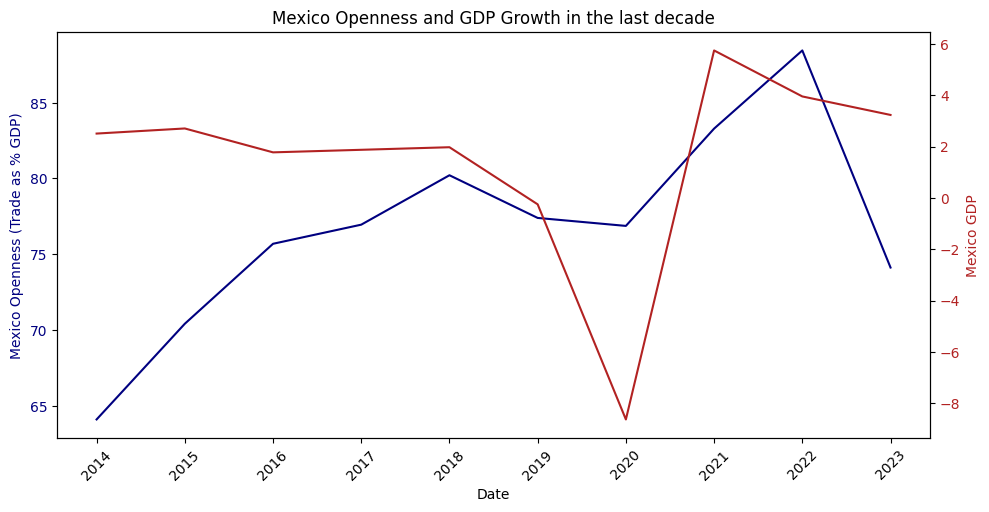

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))


ax1.plot(mexico_op.index[-10:], mexico_op[-10:], color="navy", label="Mexico OP")
ax1.set_xlabel("Date")
ax1.set_ylabel("Mexico Openness (Trade as % GDP)", color="navy")
ax1.tick_params(axis="y", labelcolor="navy")
plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.plot(mexico_op.index[-10:], mexico_gdp[-10:], color="firebrick", label="Mexico GDP Growth (%)")
ax2.set_ylabel("Mexico GDP", color="firebrick")
ax2.tick_params(axis="y", labelcolor="firebrick")

fig.tight_layout()
plt.title("Mexico Openness and GDP Growth in the last decade")
plt.show()

### Brazil

In [ ]:
brazil_usd_brl = 1 / er_df.loc["Brazil"]
brazil_op = op_df.loc["Brazil"].pct_change()
brazil_er = er_df.loc["Brazil"]

<ipython-input-179-7272f2a95efc>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  brazil_op = op_df.loc["Brazil"].pct_change()


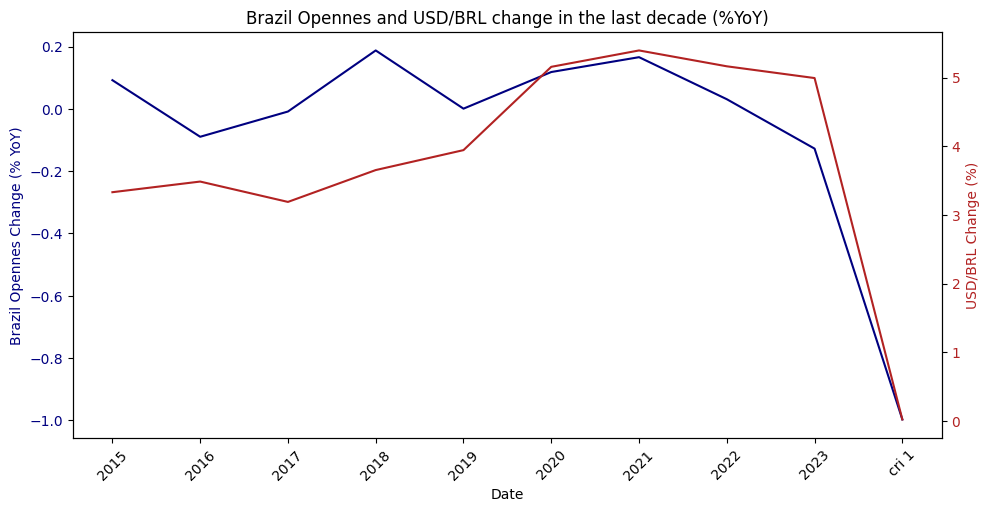

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(brazil_op.index[-10:], brazil_op[-10:], color="navy", label="Brazil CA")
ax1.set_xlabel("Date")
ax1.set_ylabel("Brazil Opennes Change (% YoY)", color="navy")
ax1.tick_params(axis="y", labelcolor="navy")
plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.plot(brazil_er.index[-10:], brazil_er[-10:], color="firebrick", label="USD/BRL Change (%)")
ax2.set_ylabel("USD/BRL Change (%)", color="firebrick")
ax2.tick_params(axis="y", labelcolor="firebrick")

fig.tight_layout()
plt.title("Brazil Opennes and USD/BRL change in the last decade (%YoY)")
plt.show()

### Nigeria

In [ ]:
gs_new = gc.open('data').worksheet('wdb gov score')
gs_df_new = pd.DataFrame(gs_new.get_all_records()) #extract data from google sheet
er_new = gc.open('data').worksheet('yearly exchange rates')
er_df_new = pd.DataFrame(er_new.get_all_records()) #extract data from google sheet
ca_new = gc.open('data').worksheet('wb current account')
ca_df_new = pd.DataFrame(ca_new.get_all_records()) #extract data from google

In [ ]:
ca_df_new['Country Code']

0      ABW
1      AFE
2      AFG
3      AFW
4      AGO
      ... 
261    XKX
262    YEM
263    ZAF
264    ZMB
265    ZWE
Name: Country Code, Length: 266, dtype: object

In [ ]:
nigeria_gs = gs_df_new[gs_df_new['Country/Territory'] == "Nigeria"].loc[:, "2000":"2022"]
nigeria_er = er_df_new[er_df_new['Country Code'] == "NGA"].loc[:, "2000":"2023"]
nigeria_ca = ca_df_new[ca_df_new['Country Code'] == "NGA"].loc[:, "2000":"2023"]

In [ ]:
nigeria_er

2000     2001      2002      2003     2004      2005     2006  \
151  104.9727  115.623  122.3799  133.0417  133.919  132.2129  128.496   

         2007      2008      2009  ...      2013      2014     2015      2016  \
151  125.7047  119.0071  149.7682  ...  159.2448  165.1708  197.874  258.5106   

         2017     2018      2019      2020      2021      2022  
151  334.0375  361.683  361.1092  381.1025  407.1603  426.0736  

[1 rows x 23 columns]

In [ ]:
nigeria_ca[-10:]

2000      2001      2002      2003       2004       2005       2006  \
174  10.737177  3.368455  1.139468  3.237197  12.404205  20.794045  15.314243   

         2007      2008      2009  ...     2013      2014      2015      2016  \
174  9.936093  8.585345  4.701382  ...  3.66244  0.157883 -3.131401  1.254721   

         2017      2018      2019      2020      2021     2022  
174  3.609826  1.726933 -2.884028 -3.698743 -0.738175  0.21552  

[1 rows x 23 columns]

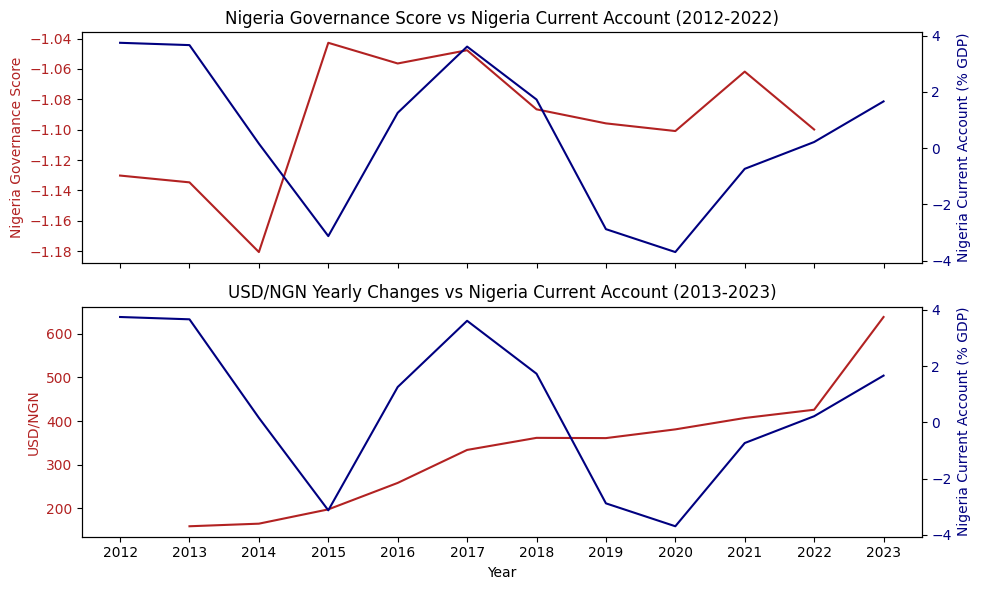

In [ ]:
import matplotlib.pyplot as plt

# Select only the last ten years (2012-2022) for each DataFrame
nigeria_gs_last_10 = nigeria_gs.loc[:, "2012":"2022"]
nigeria_er_last_10 = nigeria_er.loc[:, "2013":"2023"]
nigeria_ca_last_10 = nigeria_ca.loc[:, "2012":"2023"]

# Plot Nigeria GS vs Nigeria CA and Nigeria ER vs Nigeria CA with Nigeria CA as a secondary y-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# First plot: nigeria_gs vs nigeria_ca
ax1.plot(nigeria_gs_last_10.columns, nigeria_gs_last_10.values.flatten(), color="firebrick", label="Nigeria GS")
ax1.set_ylabel("Nigeria Governance Score", color="firebrick")
ax1.tick_params(axis="y", labelcolor="firebrick")
ax1.set_title("Nigeria Governance Score vs Nigeria Current Account (2012-2022)")

# Add secondary y-axis for nigeria_ca in the first subplot
ax1_ca = ax1.twinx()
ax1_ca.plot(nigeria_ca_last_10.columns, nigeria_ca_last_10.values.flatten(), color="navy", label="Nigeria CA")
ax1_ca.set_ylabel("Nigeria Current Account (% GDP)", color="navy")
ax1_ca.tick_params(axis="y", labelcolor="navy")

# Second plot: nigeria_er vs nigeria_ca
ax2.plot(nigeria_er_last_10.columns, nigeria_er_last_10.values.flatten(), color="firebrick", label="Nigeria ER")
ax2.set_xlabel("Year")
ax2.set_ylabel("USD/NGN", color="firebrick")
ax2.tick_params(axis="y", labelcolor="firebrick")
ax2.set_title("USD/NGN Yearly Changes vs Nigeria Current Account (2013-2023)")

# Add secondary y-axis for nigeria_ca in the second subplot
ax2_ca = ax2.twinx()
ax2_ca.plot(nigeria_ca_last_10.columns, nigeria_ca_last_10.values.flatten(), color="navy", label="Nigeria CA")
ax2_ca.set_ylabel("Nigeria Current Account (% GDP)", color="navy")
ax2_ca.tick_params(axis="y", labelcolor="navy")

# Rotate x-axis labels for readability
plt.xticks(rotation=45)
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()


## CRI Analysis per Country Results

At this point we have all the indicators, weights and what ever we need for a credit risk analysis!

- filtered_agg_gdp_df = dataframe containing GDP for each country (labeled by aggregation) in countries_to_keep during years in years_to_keep. It is indexed by counry name!
- filtered_weights_df = dataframe containing GDP per each country (labeled by aggregation)in countries_to_keep during years in years_to_keep. It is indexed by country name!
- countries_to_keep = list of countries contributing to >99.5% of world GDP
- years_to_keep = list of years we are going to analyze

-------------------------------------------------------------

- gs_df = contains datafor governance score (abs value positive and negative)
- op_df = contains the data for openness (trade as % of GDP)
- er_df = contains the data for exchange rates (LCU vs USD)
- gr_df = contains the data for gdp growth (yoy %)
- inf_df = contains the data for inflation rates (yoy %)
- ob_df = contains the data for overall balance (lending/borrowing as % GDP)
- gd_df = contains the data for gross debt (% GDP)
- std_df = contains the data for short term debts (USD abs value)
- ltd_df = contains the data for long term debts (USD abs value)
- ca_df = = contains the data for current account (% GDP)

each dataframe contains 91 countries (only exchange rates is made of 86 countries, for example data were not available for serbia and north macedonia)

each dataframe goes from 1999 to 2023

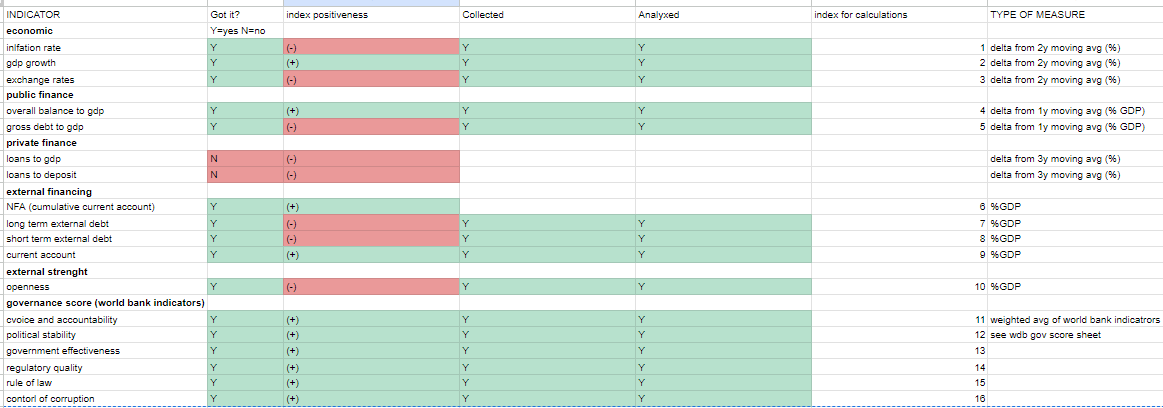

### Analysis #1: Using measurements defined here above!

We use last data year with plenty of data (2022) as a reference and we move backwards for calculating deltas form j years averages.
Since our timeframe is year we have a data point for each year, hence we are gonna take a longer average to have at least significant k data points

#### Economic Indicators

In [ ]:
inf_dict = {}
gr_dict = {}
er_dict = {}

In [ ]:
inf_df

1999       2000       2001       2002      2003  \
Country Name                                                                 
Albania                0.389438   0.050018   3.107588   7.770526  0.484003   
United Arab Emirates                                                         
Argentina                                                                    
Australia              1.483129   4.457435   4.407135   2.981575  2.732596   
Austria                0.568994   2.344863   2.650001   1.810358  1.355554   
...                         ...        ...        ...        ...       ...   
Tunisia                2.690125   2.962308   1.983333   2.721033  2.712592   
Ukraine               22.683672  28.203097  11.958809   0.757421  5.179678   
Uruguay                5.658688   4.763825   4.359341  13.972473  19.37973   
United States          2.188027   3.376857   2.826171   1.586032  2.270095   
Uzbekistan                                                                   

                          2004       2005      2006      2007       2008  ...  \
Country Name                                                              ...   
Albania               2.280019   2.366582  2.370728  2.932682   3.320871  ...   
United Arab Emirates                                            12.25042  ...   
Argentina                                                                 ...   
Australia             2.343255   2.691832  3.555288  2.327611   4.350299  ...   
Austria               2.061206   2.299138  1.441549  2.168555    3.21595  ...   
...                        ...        ...       ...       ...        ...  ...   
Tunisia                3.63228   2.017786  3.225253  2.966944   4.345028  ...   
Ukraine               9.048068  13.569576  9.052525  12.83878  25.226462  ...   
Uruguay               9.157605   4.699277   6.39765  8.114646   7.877074  ...   
United States         2.677237   3.392747  3.225944  2.852672     3.8391  ...   
Uzbekistan                                                                ...   

                           2014       2015      2016       2017       2018  \
Country Name                                                                 
Albania                1.625865   1.896174  1.275432   1.986661    2.02806   
United Arab Emirates   2.346269   4.069966  1.617488   1.966826   3.068634   
Argentina                                                                    
Australia              2.487923   1.508367  1.276991   1.948647   1.911401   
Austria                1.605812   0.896563  0.891592   2.081269    1.99838   
...                         ...        ...       ...        ...        ...   
Tunisia                4.625551   4.437371  3.629399   5.308848   7.307592   
Ukraine               12.071856  48.699865  13.91271  14.438323  10.951856   
Uruguay                8.877353    8.66627  9.639413   6.218094   7.606534   
United States          1.622223   0.118627  1.261583    2.13011   2.442583   
Uzbekistan             9.283094   8.751882  8.130887  13.875743   17.52418   

                           2019      2020      2021       2022       2023  
Country Name                                                               
Albania                1.411091  1.620887  2.041472   6.725203             
United Arab Emirates  -1.931081 -2.079403  -0.01386   4.827889             
Argentina                                                                  
Australia              1.610768  0.846906   2.86391   6.594097   5.597015  
Austria                1.530896  1.381911  2.766667    8.54687   7.814134  
...                         ...       ...       ...        ...        ...  
Tunisia                6.720075  5.634151   5.70635   8.306461   9.328996  
Ukraine                7.886717  2.732492  9.363139  20.183637  12.849022  
Uruguay                7.881989  9.756406  7.747914    9.10438   5.869104  
United States           1.81221  1.233584  4.697859     8.0028   4.116338  
Uzbekistan            14.525736

In [ ]:
yta_economics = 10 # years of moving average
index = yta_economics+1 #sum 1 to consider the python3 indexing

#inflation rates calculated as varaition from moving avg (%)
inf_mav = inf_df[inf_df.columns[-index:-2]].apply(pd.to_numeric,errors ='coerce').mean(axis=1)
#inf_mav = inf_df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce').rolling(window=yta_economics, axis=1).mean().iloc[:, -1]
inf_last = inf_df.iloc[:,-3].apply(pd.to_numeric,errors ='coerce')
inf_df['cri 1'] = (inf_last-inf_mav)/inf_mav*100
inf_df['cri 1'] = (inf_df['cri 1'] - inf_df['cri 1'].min()) / (inf_df['cri 1'].max() - inf_df['cri 1'].min())
inf_df['cri 1'].fillna(inf_df['cri 1'].median(skipna=True),inplace=True)
#gdp growth rates calculated as varaition from moving avg (%)
gr_mav = gr_df[gr_df.columns[-index:-2]].apply(pd.to_numeric,errors ='coerce').mean(axis=1)
#gr_mav = inf_df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce').rolling(window=yta_economics, axis=1).mean().iloc[:, -1]
gr_last = gr_df.iloc[:,-3].apply(pd.to_numeric,errors ='coerce')
gr_df['cri 1'] = (gr_last-gr_mav)/gr_mav*100
gr_df['cri 1'] = (gr_df['cri 1'] - gr_df['cri 1'].min()) / (gr_df['cri 1'].max() - gr_df['cri 1'].min())
gr_df['cri 1'].fillna(gr_df['cri 1'].median(skipna=True),inplace=True)
#exchange rates calculated as varaition from moving avg (%)
er_mav = er_df[er_df.columns[-index:-2]].apply(pd.to_numeric,errors ='coerce').mean(axis=1)
#er_mav = inf_df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce').rolling(window=yta_economics, axis=1).mean().iloc[:, -1]
er_last = er_df.iloc[:,-3].apply(pd.to_numeric,errors ='coerce')
er_df['cri 1'] = (er_last-er_mav)/er_mav*100
er_df['cri 1'] = (er_df['cri 1'] - er_df['cri 1'].min()) / (er_df['cri 1'].max() - er_df['cri 1'].min())
er_df['cri 1'].fillna(er_df['cri 1'].median(skipna=True),inplace=True)

<ipython-input-86-6c841b9bbdf1>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inf_df['cri 1'].fillna(inf_df['cri 1'].median(skipna=True),inplace=True)
<ipython-input-86-6c841b9bbdf1>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

In [ ]:
inf_dict['yta_10'] = inf_df.copy()
gr_dict['yta_10'] = gr_df.copy()
er_dict['yta_10'] = er_df.copy()

In [ ]:
yta_economics = 5 # years of moving average
index = yta_economics+1 #sum 1 to consider the python3 indexing


#inflation rates calculated as varaition from moving avg (%)
inf_mav = inf_df[inf_df.columns[-index:-2]].apply(pd.to_numeric,errors ='coerce').mean(axis=1)
#inf_mav = inf_df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce').rolling(window=yta_economics, axis=1).mean().iloc[:, -1]
inf_last = inf_df.iloc[:,-3].apply(pd.to_numeric,errors ='coerce')
inf_df['cri 1'] = (inf_last-inf_mav)/inf_mav*100
inf_df['cri 1'] = (inf_df['cri 1'] - inf_df['cri 1'].min()) / (inf_df['cri 1'].max() - inf_df['cri 1'].min())
inf_df['cri 1'].fillna(inf_df['cri 1'].median(skipna=True),inplace=True)
#gdp growth rates calculated as varaition from moving avg (%)
gr_mav = gr_df[gr_df.columns[-index:-2]].apply(pd.to_numeric,errors ='coerce').mean(axis=1)
#gr_mav = inf_df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce').rolling(window=yta_economics, axis=1).mean().iloc[:, -1]
gr_last = gr_df.iloc[:,-3].apply(pd.to_numeric,errors ='coerce')
gr_df['cri 1'] = (gr_last-gr_mav)/gr_mav*100
gr_df['cri 1'] = (gr_df['cri 1'] - gr_df['cri 1'].min()) / (gr_df['cri 1'].max() - gr_df['cri 1'].min())
gr_df['cri 1'].fillna(gr_df['cri 1'].median(skipna=True),inplace=True)
#exchange rates calculated as varaition from moving avg (%)
er_mav = er_df[er_df.columns[-index:-2]].apply(pd.to_numeric,errors ='coerce').mean(axis=1)
#er_mav = inf_df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce').rolling(window=yta_economics, axis=1).mean().iloc[:, -1]
er_last = er_df.iloc[:,-3].apply(pd.to_numeric,errors ='coerce')
er_df['cri 1'] = (er_last-er_mav)/er_mav*100
er_df['cri 1'] = (er_df['cri 1'] - er_df['cri 1'].min()) / (er_df['cri 1'].max() - er_df['cri 1'].min())
er_df['cri 1'].fillna(er_df['cri 1'].median(skipna=True),inplace=True)

<ipython-input-88-57ec4fca4699>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inf_df['cri 1'].fillna(inf_df['cri 1'].median(skipna=True),inplace=True)
<ipython-input-88-57ec4fca4699>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

In [ ]:
inf_dict['yta_5'] = inf_df.copy()
gr_dict['yta_5'] = gr_df.copy()
er_dict['yta_5'] = er_df.copy()

In [ ]:
yta_economics = 3 # years of moving average
index = yta_economics+1 #sum 1 to consider the python3 indexing


#inflation rates calculated as varaition from moving avg (%)
inf_mav = inf_df[inf_df.columns[-index:-2]].apply(pd.to_numeric,errors ='coerce').mean(axis=1)
#inf_mav = inf_df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce').rolling(window=yta_economics, axis=1).mean().iloc[:, -1]
inf_last = inf_df.iloc[:,-3].apply(pd.to_numeric,errors ='coerce')
inf_df['cri 1'] = (inf_last-inf_mav)/inf_mav*100
inf_df['cri 1'] = (inf_df['cri 1'] - inf_df['cri 1'].min()) / (inf_df['cri 1'].max() - inf_df['cri 1'].min())
inf_df['cri 1'].fillna(inf_df['cri 1'].median(skipna=True),inplace=True)
#gdp growth rates calculated as varaition from moving avg (%)
gr_mav = gr_df[gr_df.columns[-index:-2]].apply(pd.to_numeric,errors ='coerce').mean(axis=1)
#gr_mav = inf_df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce').rolling(window=yta_economics, axis=1).mean().iloc[:, -1]
gr_last = gr_df.iloc[:,-3].apply(pd.to_numeric,errors ='coerce')
gr_df['cri 1'] = (gr_last-gr_mav)/gr_mav*100
gr_df['cri 1'] = (gr_df['cri 1'] - gr_df['cri 1'].min()) / (gr_df['cri 1'].max() - gr_df['cri 1'].min())
gr_df['cri 1'].fillna(gr_df['cri 1'].median(skipna=True),inplace=True)
#exchange rates calculated as varaition from moving avg (%)
er_mav = er_df[er_df.columns[-index:-2]].apply(pd.to_numeric,errors ='coerce').mean(axis=1)
#er_mav = inf_df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce').rolling(window=yta_economics, axis=1).mean().iloc[:, -1]
er_last = er_df.iloc[:,-3].apply(pd.to_numeric,errors ='coerce')
er_df['cri 1'] = (er_last-er_mav)/er_mav*100
er_df['cri 1'] = (er_df['cri 1'] - er_df['cri 1'].min()) / (er_df['cri 1'].max() - er_df['cri 1'].min())
er_df['cri 1'].fillna(er_df['cri 1'].median(skipna=True),inplace=True)

<ipython-input-90-9c049d21c94a>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inf_df['cri 1'].fillna(inf_df['cri 1'].median(skipna=True),inplace=True)
<ipython-input-90-9c049d21c94a>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

In [ ]:
inf_dict['yta_3'] = inf_df.copy()
gr_dict['yta_3'] = gr_df.copy()
er_dict['yta_3'] = er_df.copy()

In [ ]:
inf_dict

{'yta_10':                            1999       2000       2001       2002      2003  \
 Country Name                                                                 
 Albania                0.389438   0.050018   3.107588   7.770526  0.484003   
 United Arab Emirates                                                         
 Argentina                                                                    
 Australia              1.483129   4.457435   4.407135   2.981575  2.732596   
 Austria                0.568994   2.344863   2.650001   1.810358  1.355554   
 ...                         ...        ...        ...        ...       ...   
 Tunisia                2.690125   2.962308   1.983333   2.721033  2.712592   
 Ukraine               22.683672  28.203097  11.958809   0.757421  5.179678   
 Uruguay                5.658688   4.763825   4.359341  13.972473  19.37973   
 United States          2.188027   3.376857   2.826171   1.586032  2.270095   
 Uzbekistan                               

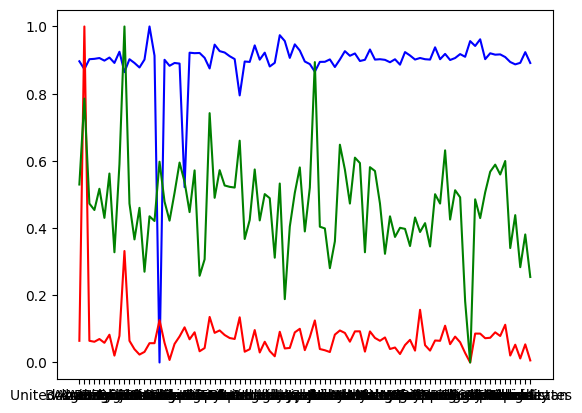

In [ ]:
#check influence of inflation rates
plt.plot(inf_dict['yta_10'].index,inf_dict['yta_10']['cri 1'],color='blue')
plt.plot(inf_dict['yta_5'].index,inf_dict['yta_5']['cri 1'],color='red')
plt.plot(inf_dict['yta_3'].index,inf_dict['yta_3']['cri 1'],color='green')

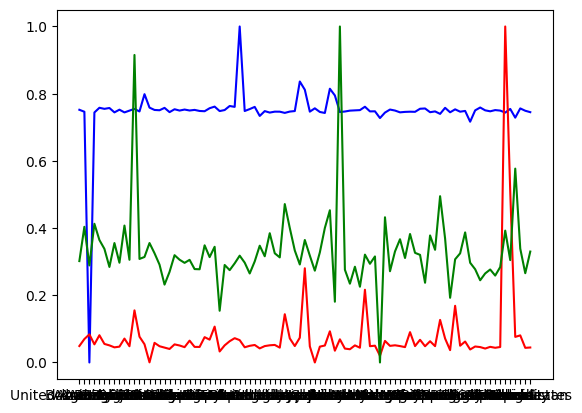

In [ ]:
#check influence of GDP growth
plt.plot(gr_dict['yta_10'].index,gr_dict['yta_10']['cri 1'],color='blue')
plt.plot(gr_dict['yta_5'].index,gr_dict['yta_5']['cri 1'],color='red')
plt.plot(gr_dict['yta_3'].index,gr_dict['yta_3']['cri 1'],color='green')

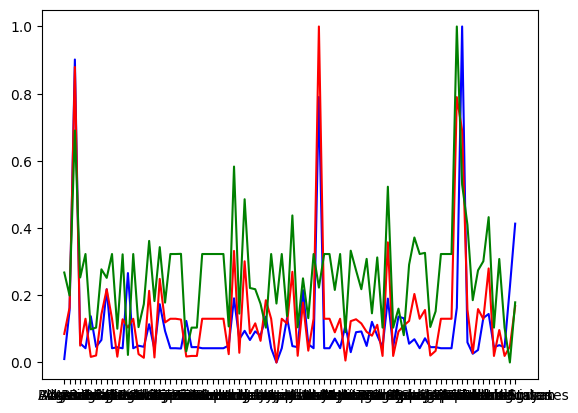

In [ ]:
#check influence of exchange rates
plt.plot(er_dict['yta_10'].index,er_dict['yta_10']['cri 1'],color='blue')
plt.plot(er_dict['yta_5'].index,er_dict['yta_5']['cri 1'],color='red')
plt.plot(er_dict['yta_3'].index,er_dict['yta_3']['cri 1'],color='green')

#### Finance Indicators

In [ ]:
ob_dict = {}
gd_dict = {}

In [ ]:
yta_finance = 7 # years of moving average
index = yta_finance+1
#overall balance
ob_mav = ob_df[ob_df.columns[-index:-2]].apply(pd.to_numeric,errors ='coerce').mean(axis=1)
#ob_mav = inf_df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce').rolling(window=yta_finance, axis=1).mean().iloc[:, -1]
ob_last = ob_df.iloc[:,-3].apply(pd.to_numeric,errors ='coerce')
ob_df['cri 1'] = (ob_last-ob_mav)/ob_mav*100
ob_df['cri 1'] = (ob_df['cri 1'] - ob_df['cri 1'].min()) / (ob_df['cri 1'].max() - ob_df['cri 1'].min())
ob_df['cri 1'].fillna(ob_df['cri 1'].median(skipna=True),inplace=True)
# gross debt
gd_mav = gd_df[gd_df.columns[-index:-2]].apply(pd.to_numeric,errors ='coerce').mean(axis=1)
#gd_mav = inf_df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce').rolling(window=yta_finance, axis=1).mean().iloc[:, -1]
gd_last = gd_df.iloc[:,-3].apply(pd.to_numeric,errors ='coerce')
gd_df['cri 1'] = (gd_last-gd_mav)/gd_mav*100
gd_df['cri 1'] = (gd_df['cri 1'] - gd_df['cri 1'].min()) / (gd_df['cri 1'].max() - gd_df['cri 1'].min())
gd_df['cri 1'].fillna(gd_df['cri 1'].median(skipna=True),inplace=True)

<ipython-input-97-ee8e5337fdce>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ob_df['cri 1'].fillna(ob_df['cri 1'].median(skipna=True),inplace=True)
<ipython-input-97-ee8e5337fdce>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

In [ ]:
ob_dict['yta_5'] = ob_df.copy()
gd_dict['yta_5'] = gd_df.copy()

In [ ]:
yta_finance = 5 # years of moving average
index = yta_finance+1
#overall balance
ob_mav = ob_df[ob_df.columns[-index:-2]].apply(pd.to_numeric,errors ='coerce').mean(axis=1)
#ob_mav = inf_df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce').rolling(window=yta_finance, axis=1).mean().iloc[:, -1]
ob_last = ob_df.iloc[:,-3].apply(pd.to_numeric,errors ='coerce')
ob_df['cri 1'] = (ob_last-ob_mav)/ob_mav*100
ob_df['cri 1'] = (ob_df['cri 1'] - ob_df['cri 1'].min()) / (ob_df['cri 1'].max() - ob_df['cri 1'].min())
ob_df['cri 1'].fillna(ob_df['cri 1'].median(skipna=True),inplace=True)
# gross debt
gd_mav = gd_df[gd_df.columns[-index:-2]].apply(pd.to_numeric,errors ='coerce').mean(axis=1)
#gd_mav = inf_df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce').rolling(window=yta_finance, axis=1).mean().iloc[:, -1]
gd_last = gd_df.iloc[:,-3].apply(pd.to_numeric,errors ='coerce')
gd_df['cri 1'] = (gd_last-gd_mav)/gd_mav*100
gd_df['cri 1'] = (gd_df['cri 1'] - gd_df['cri 1'].min()) / (gd_df['cri 1'].max() - gd_df['cri 1'].min())
gd_df['cri 1'].fillna(gd_df['cri 1'].median(skipna=True),inplace=True)

<ipython-input-99-b3aa2e16bb0a>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ob_df['cri 1'].fillna(ob_df['cri 1'].median(skipna=True),inplace=True)
<ipython-input-99-b3aa2e16bb0a>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

In [ ]:
ob_dict['yta_3'] = ob_df.copy()
gd_dict['yta_3'] = gd_df.copy()

In [ ]:
yta_finance = 3 # years of moving average
index = yta_finance+1
#overall balance
ob_mav = ob_df[ob_df.columns[-index:-2]].apply(pd.to_numeric,errors ='coerce').mean(axis=1)
#ob_mav = inf_df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce').rolling(window=yta_finance, axis=1).mean().iloc[:, -1]
ob_last = ob_df.iloc[:,-3].apply(pd.to_numeric,errors ='coerce')
ob_df['cri 1'] = (ob_last-ob_mav)/ob_mav*100
ob_df['cri 1'] = (ob_df['cri 1'] - ob_df['cri 1'].min()) / (ob_df['cri 1'].max() - ob_df['cri 1'].min())
ob_df['cri 1'].fillna(ob_df['cri 1'].median(skipna=True),inplace=True)
# gross debt
gd_mav = gd_df[gd_df.columns[-index:-2]].apply(pd.to_numeric,errors ='coerce').mean(axis=1)
#gd_mav = inf_df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce').rolling(window=yta_finance, axis=1).mean().iloc[:, -1]
gd_last = gd_df.iloc[:,-3].apply(pd.to_numeric,errors ='coerce')
gd_df['cri 1'] = (gd_last-gd_mav)/gd_mav*100
gd_df['cri 1'] = (gd_df['cri 1'] - gd_df['cri 1'].min()) / (gd_df['cri 1'].max() - gd_df['cri 1'].min())
gd_df['cri 1'].fillna(gd_df['cri 1'].median(skipna=True),inplace=True)

<ipython-input-101-173be1379a80>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ob_df['cri 1'].fillna(ob_df['cri 1'].median(skipna=True),inplace=True)
<ipython-input-101-173be1379a80>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value,

In [ ]:
ob_dict['yta_2'] = ob_df.copy()
gd_dict['yta_2'] = gd_df.copy()

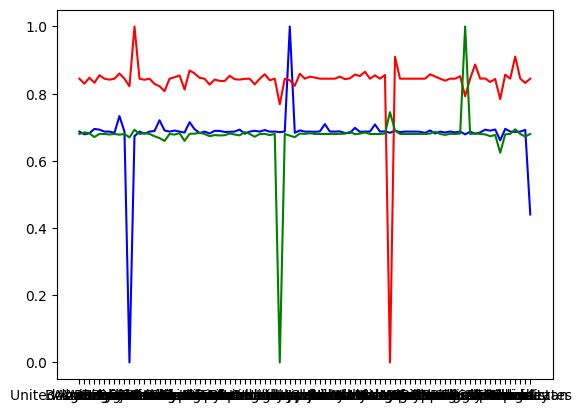

In [ ]:
#check influence of overall balance
plt.plot(ob_dict['yta_5'].index,ob_dict['yta_5']['cri 1'],color='blue')
plt.plot(ob_dict['yta_3'].index,ob_dict['yta_3']['cri 1'],color='red')
plt.plot(ob_dict['yta_2'].index,ob_dict['yta_2']['cri 1'],color='green')

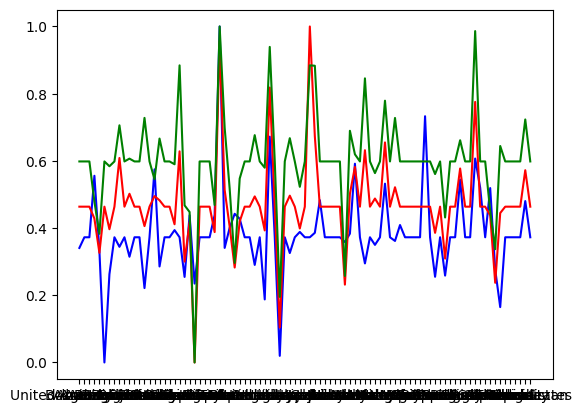

In [ ]:
#check influence of gross debt

plt.plot(gd_dict['yta_5'].index,gd_dict['yta_5']['cri 1'],color='blue')
plt.plot(gd_dict['yta_3'].index,gd_dict['yta_3']['cri 1'],color='red')
plt.plot(gd_dict['yta_2'].index,gd_dict['yta_2']['cri 1'],color='green')

#### External Financing

lt and st debt are full of nan values, thus we will remove it from the CRI analysis

In [ ]:
#current account
ca_df['cri 1'] = ca_df['2022'].replace('', np.nan).astype(float)
ca_df['cri 1'] = (ca_df['cri 1'] - ca_df['cri 1'].min()) / (ca_df['cri 1'].max() - ca_df['cri 1'].min())
ca_df['cri 1'].fillna(ca_df['cri 1'].median(skipna=True),inplace=True)

<ipython-input-105-634f4660b5c5>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ca_df['cri 1'] = ca_df['2022'].replace('', np.nan).astype(float)
<ipython-input-105-634f4660b5c5>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ca_df['cri 1'].fillna(ca_df['cri 1'].median(skipna=True),inplace=True)


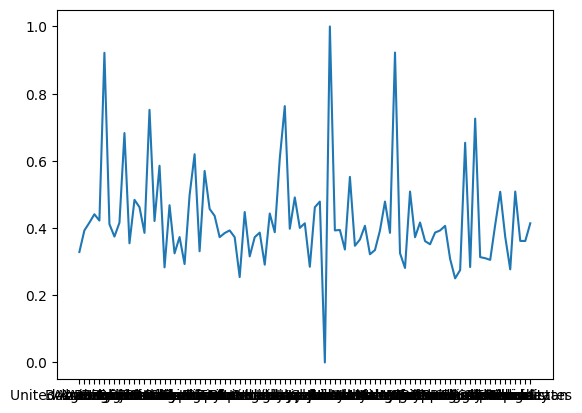

In [ ]:
plt.plot(ca_df.index,ca_df['cri 1'])

In [ ]:
#short term debt
std_df['cri 1'] = std_df['2022'].replace('', np.nan).astype(float)
std_df['cri 1'] = (std_df['cri 1'] - std_df['cri 1'].min()) / (std_df['cri 1'].max() - std_df['cri 1'].min())
std_df['cri 1'].fillna(std_df['cri 1'].median(skipna=True),inplace=True)

<ipython-input-107-d4185555373c>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  std_df['cri 1'].fillna(std_df['cri 1'].median(skipna=True),inplace=True)


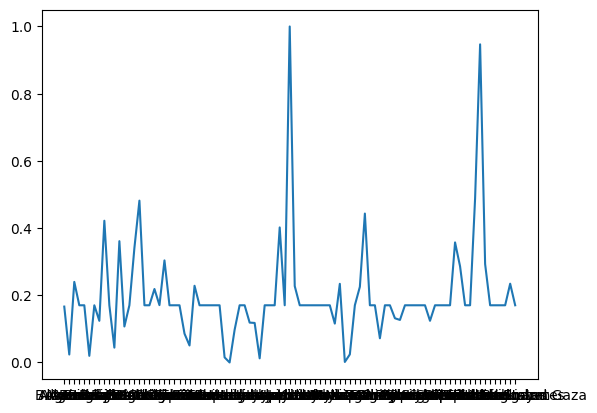

In [ ]:
plt.plot(std_df.index,std_df['cri 1'])

In [ ]:
#long term debt
ltd_df['cri 1'] = ltd_df['2022'].replace('', np.nan).astype(float)
ltd_df['cri 1'] = (ltd_df['cri 1'] - ltd_df['cri 1'].min()) / (ltd_df['cri 1'].max() - ltd_df['cri 1'].min())
ltd_df['cri 1'].fillna(ltd_df['cri 1'].median(skipna=True),inplace=True)

<ipython-input-109-ba3c9f6b1710>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ltd_df['cri 1'].fillna(ltd_df['cri 1'].median(skipna=True),inplace=True)


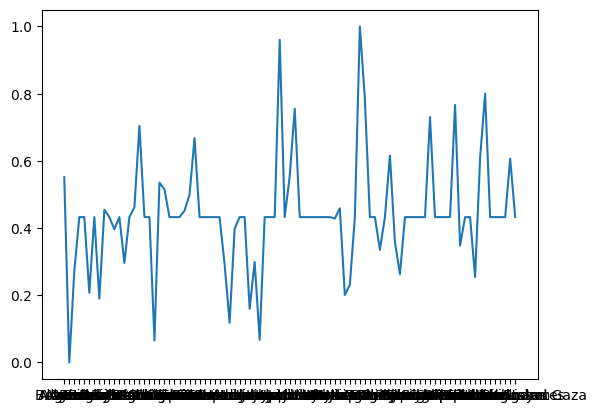

In [ ]:
plt.plot(ltd_df.index,ltd_df['cri 1'])

#### External Strenght

In [ ]:
#openness
op_df['cri 1'] = op_df['2022'].replace('', np.nan).astype(float)
op_df['cri 1'] = (op_df['cri 1'] - op_df['cri 1'].min()) / (op_df['cri 1'].max() - op_df['cri 1'].min())
op_df['cri 1'].fillna(op_df['cri 1'].median(skipna=True),inplace=True)
print(op_df['cri 1'].isna().sum())

0


<ipython-input-111-dc8776ec4474>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  op_df['cri 1'] = op_df['2022'].replace('', np.nan).astype(float)
<ipython-input-111-dc8776ec4474>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  op_df['cri 1'].fillna(op_df['cri 1'].median(skipna=True),inplace=True)


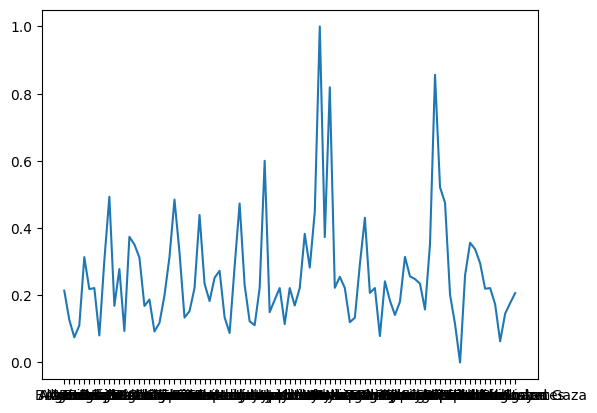

In [ ]:
plt.plot(op_df.index,op_df['cri 1'])

#### Governance

In [ ]:
gs_df['cri 1']=gs_df['2022']
gs_df['cri 1'] = (gs_df['cri 1'] - gs_df['cri 1'].min()) / (gs_df['cri 1'].max() - gs_df['cri 1'].min())

In [ ]:
gs_df

2000      2001      2002      2003      2004  \
Country/Territory                                                        
Albania               -0.67251  -0.47488   -0.4773  -0.40677  -0.52927   
United Arab Emirates  0.442401  0.665796  0.438239  0.505635  0.485934   
Argentina             0.046935  -0.46731  -0.33225  -0.35225  -0.22189   
Australia             1.616201  1.534247  1.567808  1.655738  1.566655   
Austria               1.504291  1.642968  1.597545  1.627744  1.587794   
...                        ...       ...       ...       ...       ...   
Uruguay                0.76602  0.776279  0.705061  0.564544   0.68568   
United States         1.497036  1.365536  1.297708  1.270635  1.239448   
Uzbekistan            -1.44657  -1.33165  -1.30627   -1.4042  -1.55582   
West Bank and Gaza    -0.76421  -0.87492  -0.80858  -0.59466  -0.85949   
Serbia                 -1.0679  -0.58373  -0.56313  -0.43892  -0.55151   

                          2005      2006      2007      2008      2009  ...  \
Country/Territory                                                       ...   
Albania               -0.44258  -0.30877  -0.21504  -0.15963  -0.17187  ...   
United Arab Emirates  0.448575  0.483571  0.456386  0.473124   0.39061  ...   
Argentina             -0.19189  -0.17923   -0.2816  -0.36993   -0.2552  ...   
Australia             1.559412  1.591001  1.609998  1.588762  1.591554  ...   
Austria               1.620596  1.692264  1.635884  1.527992   1.54055  ...   
...                        ...       ...       ...       ...       ...  ...   
Uruguay               0.731994  0.784372  0.800954  0.838527  0.881444  ...   
United States         1.292107  1.268244  1.321801   1.22061  1.244071  ...   
Uzbekistan            -1.52346  -1.39736  -1.30117  -1.29529  -1.30014  ...   
West Bank and Gaza     -0.8161  -0.93311  -1.07434  -0.71752  -0.54677  ...   
Serbia                -0.31776  -0.29742  -0.28197  -0.19808  -0.17122  ...   

                          2014      2015      2016      2017      2018  \
Country/Territory                                                        
Albania               -0.00621  -0.02702  -0.01133  0.000547  -0.01133   
United Arab Emirates  0.666329  0.646961  0.636677  0.629576  0.633894   
Argentina             -0.37543  -0.30942  -0.00948  0.013792  0.010002   
Australia             1.603477  1.528702  1.549182  1.511932  1.543218   
Austria               1.517182  1.440335  1.398744  1.434994  1.447631   
...                        ...       ...       ...       ...       ...   
Uruguay               0.901541  0.869941  0.877471  0.844436  0.853499   
United States         1.228466  1.228194  1.222505  1.225468   1.21672   
Uzbekistan            -1.14687  -1.19925  -1.13214  -1.04925    -0.978   
West Bank and Gaza    -0.63596   -0.7631  -0.70511  -0.60174  -0.70701   
Serbia                0.039794  0.034451  -0.03159  -0.06467  -0.06701   

                          2019      2020      2021      2022     cri 1  
Country/Territory                                                       
Albania                -0.0879  -0.11785  -0.07237   -0.0158   0.49956  
United Arab Emirates  0.626043  0.622197  0.621241  0.650043  0.686716  
Argentina             -0.10578  -0.14833  -0.21794  -0.22897  0.439642  
Australia             1.512167  1.465772  1.474304  1.491899  0.923346  
Austria               1.425211  1.421902  1.358688  1.293313  0.867527  
...                        ...       ...       ...       ...       ...  
Uruguay               0.884873  0.965544  1.022721  1.052926  0.799959  
United States          1.06935  0.952685  1.002353   0.99425  0.783466  
Uzbekistan            -0.95545  -0.96154  -0.71059  -0.66967  0.315769  
West Bank and Gaza    -0.75814  -0.80389  -0.84576   -0.8413  0.267527  
Serbia                -0.10635  -0.13796  -0.12307   -0.1066  0.474038  

[91 rows x 24 columns]

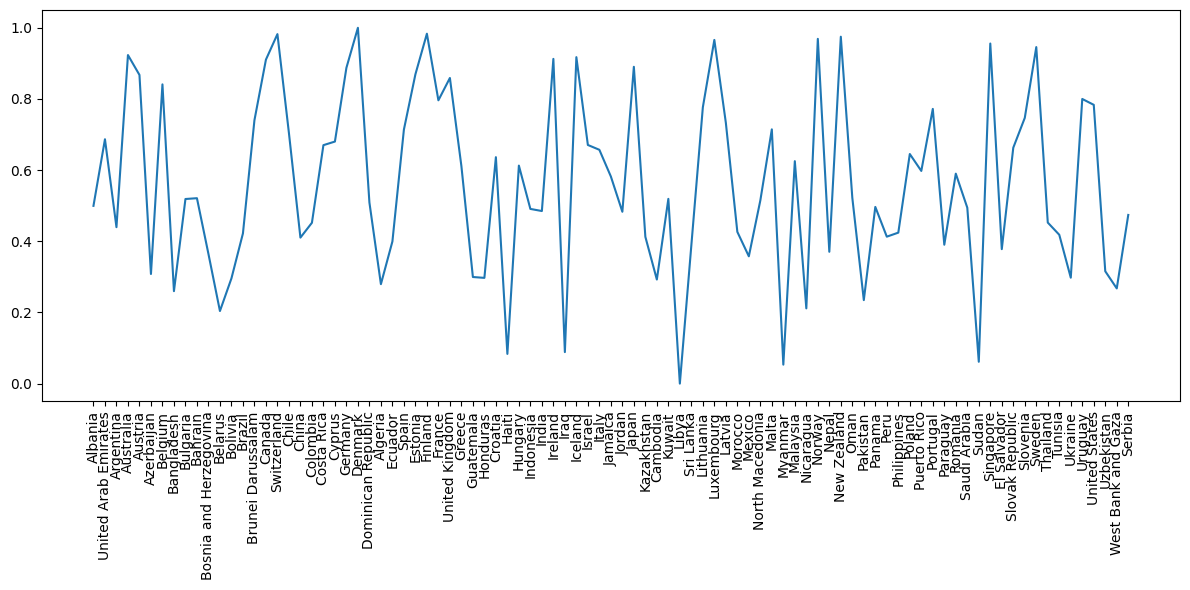

In [ ]:
plt.figure(figsize=(12, 6))  # Adjust figure size (width, height) as needed
plt.plot(gs_df.index, gs_df['cri 1'])
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

#### CRI calculation!!!

In [ ]:
cri_df_dict = {}

In [ ]:
#long term average
cri_df_lt = pd.DataFrame()
cri_df_lt['inflation rates'] = inf_dict['yta_10']['cri 1'] #negative as higher variance in inflation has negative effect
cri_df_lt['gdp growth rates'] = -gr_dict['yta_10']['cri 1']
cri_df_lt['exchange rates'] = er_dict['yta_10']['cri 1'] #same reasoning of inflation
cri_df_lt['overall balance'] = -ob_dict['yta_5']['cri 1']
cri_df_lt['gross debt'] = gd_dict['yta_5']['cri 1'] #here to debt is a negative component
cri_df_lt['current account'] = -ca_df['cri 1']
cri_df_lt['openness'] = op_df['cri 1'] #also openness reports a weakness to external shoks
cri_df_lt['governance'] = -gs_df['cri 1']
cri_df_lt['short term debt'] = std_df['cri 1']
cri_df_lt['long term debt'] = ltd_df['cri 1']


cri_df_dict['long term'] = cri_df_lt.copy()
#mediuam term average
cri_df_mt = pd.DataFrame()
cri_df_mt['inflation rates'] = inf_dict['yta_5']['cri 1'] #negative as higher variance in inflation has negative effect
cri_df_mt['gdp growth rates'] = -gr_dict['yta_5']['cri 1']
cri_df_mt['exchange rates'] = er_dict['yta_5']['cri 1'] #same reasoning of inflation
cri_df_mt['overall balance'] = -ob_dict['yta_3']['cri 1']
cri_df_mt['gross debt'] = gd_dict['yta_3']['cri 1'] #here to debt is a negative component
cri_df_mt['current account'] = -ca_df['cri 1']
cri_df_mt['openness'] = op_df['cri 1'] #also openness reports a weakness to external shoks
cri_df_mt['governance'] = -gs_df['cri 1']
cri_df_mt['short term debt'] = std_df['cri 1']
cri_df_mt['long term debt'] = ltd_df['cri 1']

cri_df_dict['medium term'] = cri_df_mt.copy()
# short term average
cri_df_st = pd.DataFrame()
cri_df_st['inflation rates'] = inf_dict['yta_3']['cri 1'] #negative as higher variance in inflation has negative effect
cri_df_st['gdp growth rates'] = -gr_dict['yta_3']['cri 1']
cri_df_st['exchange rates'] = er_dict['yta_3']['cri 1'] #same reasoning of inflation
cri_df_st['overall balance'] = -ob_dict['yta_2']['cri 1']
cri_df_st['gross debt'] = gd_dict['yta_2']['cri 1'] #here to debt is a negative component
cri_df_st['current account'] = -ca_df['cri 1']
cri_df_st['openness'] = op_df['cri 1'] #also openness reports a weakness to external shoks
cri_df_st['governance'] = -gs_df['cri 1']
cri_df_st['short term debt'] = std_df['cri 1']
cri_df_st['long term debt'] = ltd_df['cri 1']

cri_df_dict['short term'] = cri_df_st.copy()

In [ ]:
cri_df_dict

{'long term':                       inflation rates  gdp growth rates  exchange rates  \
 Country Name                                                              
 Albania                      0.896393         -0.752084        0.010236   
 United Arab Emirates         0.872893         -0.746221        0.045616   
 Argentina                    0.902565         -0.000000        0.901704   
 Australia                    0.903675         -0.744052        0.056933   
 Austria                      0.906047         -0.758041        0.042390   
 ...                               ...               ...             ...   
 Tunisia                      0.894265         -0.754614        0.132564   
 Ukraine                      0.887224         -0.728636        0.144351   
 Uruguay                      0.891767         -0.756145        0.223955   
 United States                0.923590         -0.749168        0.045616   
 Uzbekistan                   0.891304         -0.744985        0.413171   

In [ ]:
CRI_country_rank_dict = {}

# iterate over the keys in cri_df_dict to calculate the CRI and rankings
for term, df in cri_df_dict.items():
    # Calculate the Country Risk Index (CRI)
    df['CRI'] = df.sum(axis=1)
    df['CRI order'] = df['CRI'].rank(method='first', ascending=False).astype(int)

    # drop unnecessary columns to keep only the ranking information
    columns_to_drop = ['inflation rates', 'gdp growth rates', 'exchange rates',
                       'overall balance', 'gross debt', 'current account',
                       'openness', 'governance','long term debt','short term debt']
    CRI_country_rank = df.drop(columns=columns_to_drop)

    CRI_country_rank_dict[term] = CRI_country_rank


In [ ]:
CRI_country_rank_dict

{'long term':                            CRI  CRI order
 Country Name                             
 Albania              -0.088595         36
 United Arab Emirates -0.389458         59
 Argentina             1.224256          1
 Australia            -0.574496         76
 Austria              -0.544138         74
 ...                        ...        ...
 Tunisia               1.113398          3
 Ukraine               0.495451         13
 Uruguay              -0.368306         56
 United States        -0.471022         65
 Uzbekistan            0.779647          9
 
 [91 rows x 2 columns],
 'medium term':                            CRI  CRI order
 Country Name                             
 Albania              -0.177282         31
 United Arab Emirates  0.328481          9
 Argentina             0.205953         11
 Australia            -0.997634         87
 Austria              -0.783223         74
 ...                        ...        ...
 Tunisia               0.414972          8


In [ ]:
#reordering the entries based on the ranking
for term in CRI_country_rank_dict:
    CRI_country_rank_dict[term] = CRI_country_rank_dict[term].sort_values(by='CRI order')

In [ ]:
for term in CRI_country_rank_dict:
    # Extract the 'CRI' column for the current term
    cri_values = CRI_country_rank_dict[term]['CRI']

    # Apply Min-Max normalization
    normalized_cri = (cri_values - cri_values.min()) / (cri_values.max() - cri_values.min())

    # Update the 'CRI' column with the normalized values
    CRI_country_rank_dict[term]['CRI'] = normalized_cri

In [ ]:
CRI_country_rank_dict

{'long term':                    CRI  CRI order
 Country Name                     
 Argentina          1.0          1
 Sudan         0.996588          2
 Tunisia       0.962957          3
 Cambodia        0.9489          4
 Libya         0.942663          5
 ...                ...        ...
 Iceland       0.280328         87
 Denmark       0.277229         88
 Norway        0.197705         89
 Azerbaijan    0.193304         90
 Switzerland        0.0         91
 
 [91 rows x 2 columns],
 'medium term':                    CRI  CRI order
 Country Name                     
 Nicaragua          1.0          1
 Jordan        0.912036          2
 Libya         0.895945          3
 Sri Lanka     0.798696          4
 Cambodia       0.78173          5
 ...                ...        ...
 Australia     0.134551         87
 Kuwait        0.097605         88
 Azerbaijan    0.082625         89
 Norway        0.005064         90
 Denmark            0.0         91
 
 [91 rows x 2 columns],
 'short te

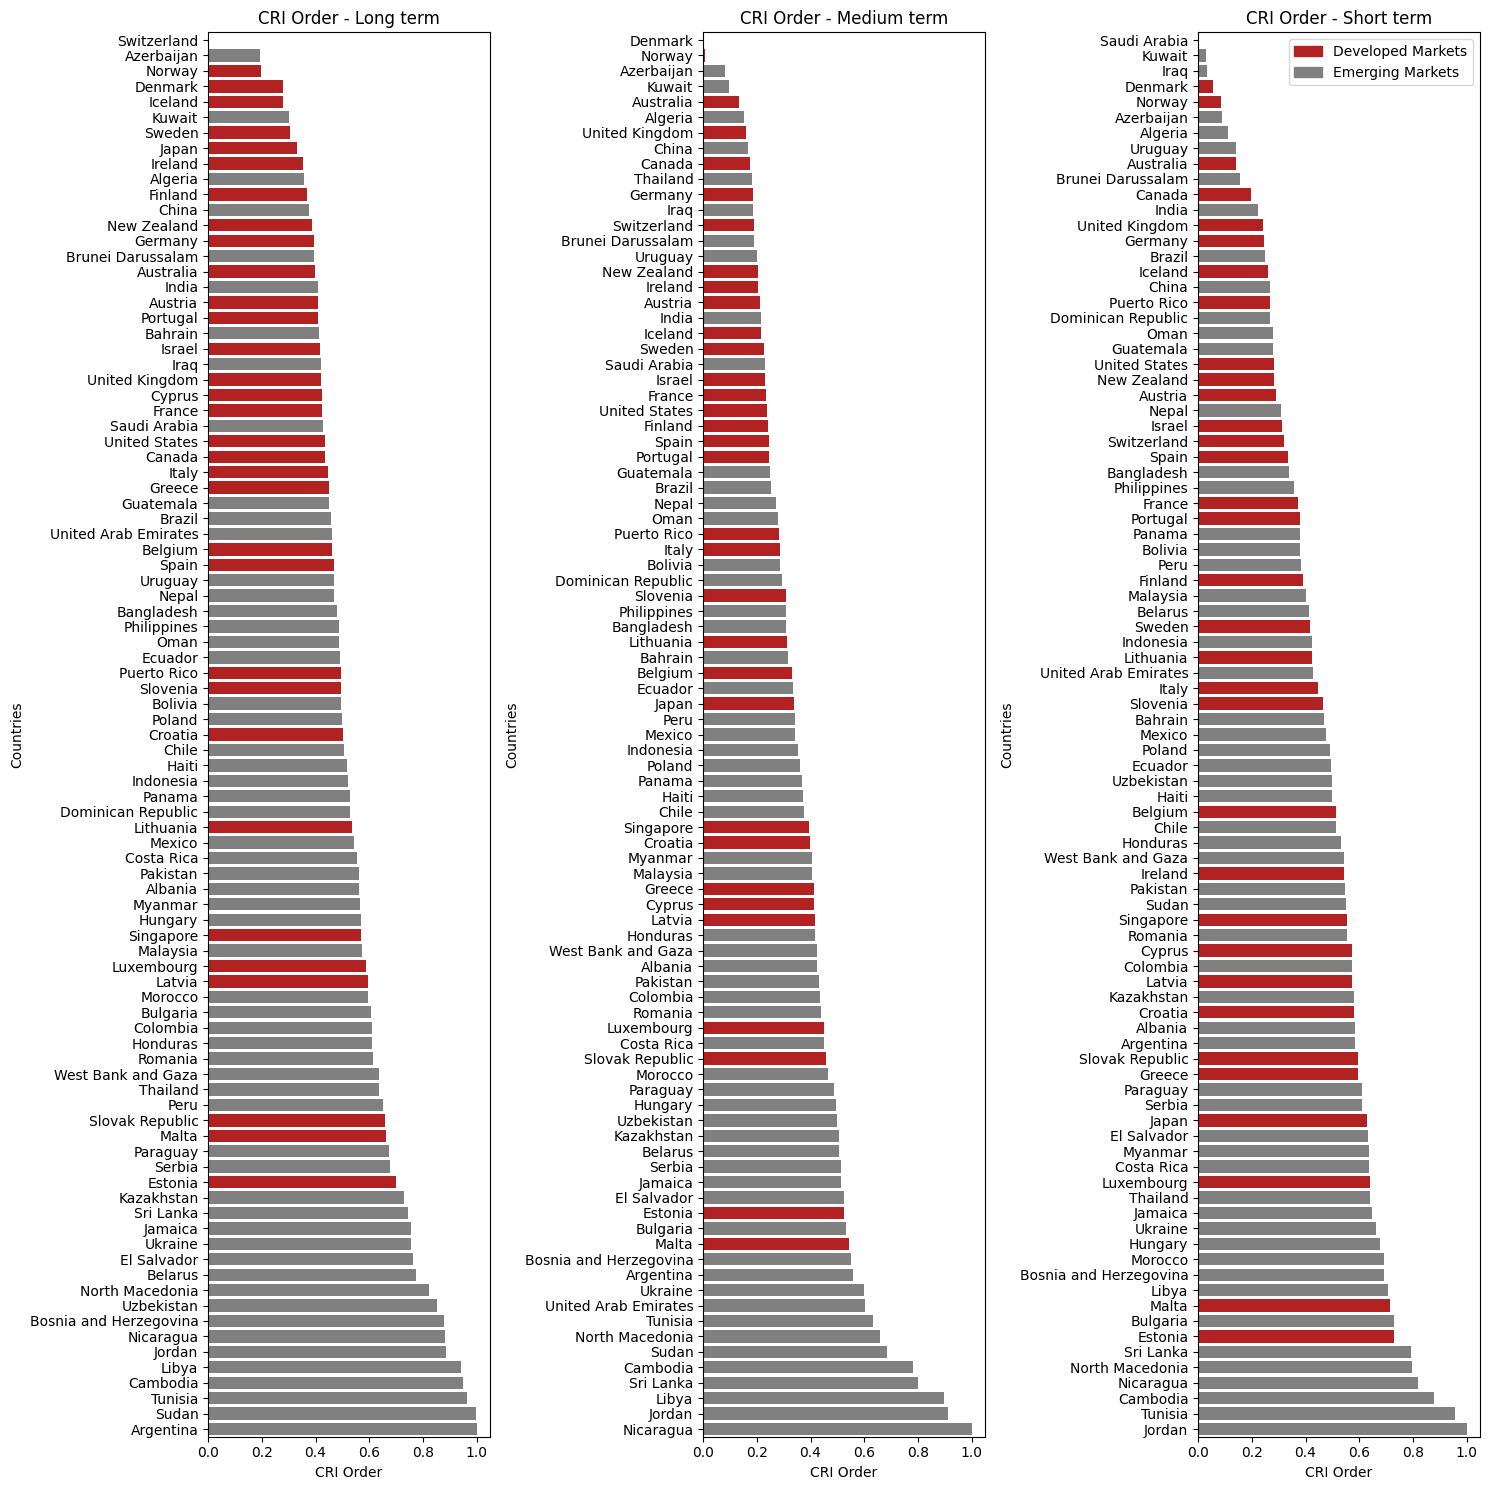

In [ ]:
import matplotlib.patches as mpatches

# Define the list of developed market countries to highlight
developed_markets = [
    "Andorra", "Australia", "Austria", "Belgium", "Canada", "Croatia", "Cyprus", "Czech Republic",
    "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hong Kong SAR", "Iceland",
    "Ireland", "Israel", "Italy", "Japan", "Korea", "Latvia", "Lithuania", "Luxembourg", "Macao SAR",
    "Malta", "The Netherlands", "New Zealand", "Norway", "Portugal", "Puerto Rico", "San Marino",
    "Singapore", "Slovak Republic", "Slovenia", "Spain", "Sweden", "Switzerland", "Taiwan Province of China",
    "United Kingdom", "United States"
]

fig, axs = plt.subplots(1, 3, figsize=(15, 15))

# Iterate through the keys and axes to plot each term's CRI rankings
for ax, (term, df) in zip(axs, CRI_country_rank_dict.items()):
    # Set color based on whether the country is in the developed markets list
    colors = ['firebrick' if country in developed_markets else 'gray' for country in df.index]

    # Plot the CRI order for the current term
    ax.barh(df.index, df['CRI'], color=colors)
    ax.set_title(f'CRI Order - {term.capitalize()}')
    ax.set_xlabel('CRI Order')
    ax.set_ylabel('Countries')

    # Invert y-axis and set limits to avoid extra space
    ax.invert_yaxis()
    ax.set_ylim(-0.5, len(df.index) - 0.5)

# Add a legend with custom patches
developed_patch = mpatches.Patch(color='firebrick', label='Developed Markets')
emerging_patch = mpatches.Patch(color='gray', label='Emerging Markets')
plt.legend(handles=[developed_patch, emerging_patch], loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## CRI Analysis per Market Group Results

### IMF classification

In [ ]:
# Initialize an empty dictionary to store the modified DataFrames
CRI_country_rank_aggregated_dict = {}

# Define the aggregate mapping
aggregate_mapping = {
    'am': dm,
    'ema': ema,
    'eme': eme,
    'latam': latam,
    'meca': meca
}

# Iterate over each term's DataFrame in the CRI_country_rank_dict
for term, df in CRI_country_rank_dict.items():
    # Adding the aggregation group to perform a per group analysis
    df['Aggregate'] = ''

    # Assign aggregate labels based on country membership
    for aggregate_label, country_list in aggregate_mapping.items():
        df.loc[df.index.isin(country_list), 'Aggregate'] = aggregate_label

    # Add the weights calculated as wi = GDPi / sum(GDPs)
    df['gdp weight'] = filtered_weights_df['2022']
    df['weighted CRI'] = df['gdp weight'] * df['CRI']

    # Drop unnecessary columns for clarity
    to_drop = ['gdp weight', 'Aggregate']
    CRI_country_rank_aggregated = df.drop(to_drop, axis=1)

    # Store the modified DataFrame in the new dictionary
    CRI_country_rank_aggregated_dict[term] = CRI_country_rank_aggregated

# Now CRI_country_rank_aggregated_dict contains the modified DataFrames for each term


In [ ]:
CRI_country_rank_aggregated

CRI  CRI order weighted CRI
Country Name                                     
Jordan                1.0          1     0.000542
Tunisia          0.955991          2     0.000474
Cambodia         0.879803          3     0.000289
Nicaragua        0.819691          4     0.000142
North Macedonia  0.796336          5     0.000121
...                   ...        ...          ...
Norway           0.083416         87     0.000551
Denmark          0.056174         88      0.00025
Iraq             0.032268         89     0.000103
Kuwait           0.029855         90     0.000061
Saudi Arabia          0.0         91          0.0

[91 rows x 3 columns]

In [ ]:
# Initialize empty dictionaries to store the aggregated DataFrames for each aggregate category
CRI_am_dict = {}
CRI_ema_dict = {}
CRI_eme_dict = {}
CRI_latam_dict = {}
CRI_meca_dict = {}

# Define the aggregate mapping
aggregate_mapping = {
    'am': dm,
    'ema': ema,
    'eme': eme,
    'latam': latam,
    'meca': meca
}

# Iterate over each term's DataFrame in the CRI_country_rank_dict
for term, df in CRI_country_rank_dict.items():
    # Adding the aggregation group to perform a per group analysis
    df['Aggregate'] = ''

    # Assign aggregate labels based on country membership
    for aggregate_label, country_list in aggregate_mapping.items():
        df.loc[df.index.isin(country_list), 'Aggregate'] = aggregate_label

    # Add the weights calculated as wi = GDPi / sum(GDPs)
    df['gdp weight'] = filtered_weights_df['2022']
    df['weighted CRI'] = df['gdp weight'] * df['CRI']

    # Create separate dictionaries for each aggregate
    for aggregate_label in aggregate_mapping.keys():
        aggregate_df = df[df['Aggregate'] == aggregate_label].drop(['gdp weight', 'Aggregate'], axis=1)

        # Store in the corresponding dictionary
        if aggregate_label == 'am':
            CRI_am_dict[term] = aggregate_df
        elif aggregate_label == 'ema':
            CRI_ema_dict[term] = aggregate_df
        elif aggregate_label == 'eme':
            CRI_eme_dict[term] = aggregate_df
        elif aggregate_label == 'latam':
            CRI_latam_dict[term] = aggregate_df
        elif aggregate_label == 'meca':
            CRI_meca_dict[term] = aggregate_df

# Now you have separate dictionaries for each aggregate category


In [ ]:
CRI_am_dict

{'long term':                       CRI  CRI order weighted CRI
 Country Name                                     
 Estonia          0.701643         17     0.000296
 Malta            0.661285         20     0.000135
 Slovak Republic  0.657846         21     0.000849
 Latvia           0.594329         30     0.000267
 Luxembourg        0.58784         31     0.000533
 Singapore         0.57123         33     0.003163
 Lithuania        0.536048         40     0.000423
 Croatia          0.501938         46     0.000402
 Slovenia         0.494559         49     0.000331
 Puerto Rico      0.493568         50     0.000626
 Spain            0.467532         57     0.007382
 Belgium          0.461192         58     0.002995
 Greece           0.451298         62     0.001094
 Italy             0.44524         63     0.010249
 Canada           0.435037         64     0.010449
 United States    0.433526         65     0.123894
 France           0.424416         67      0.01312
 Cyprus           

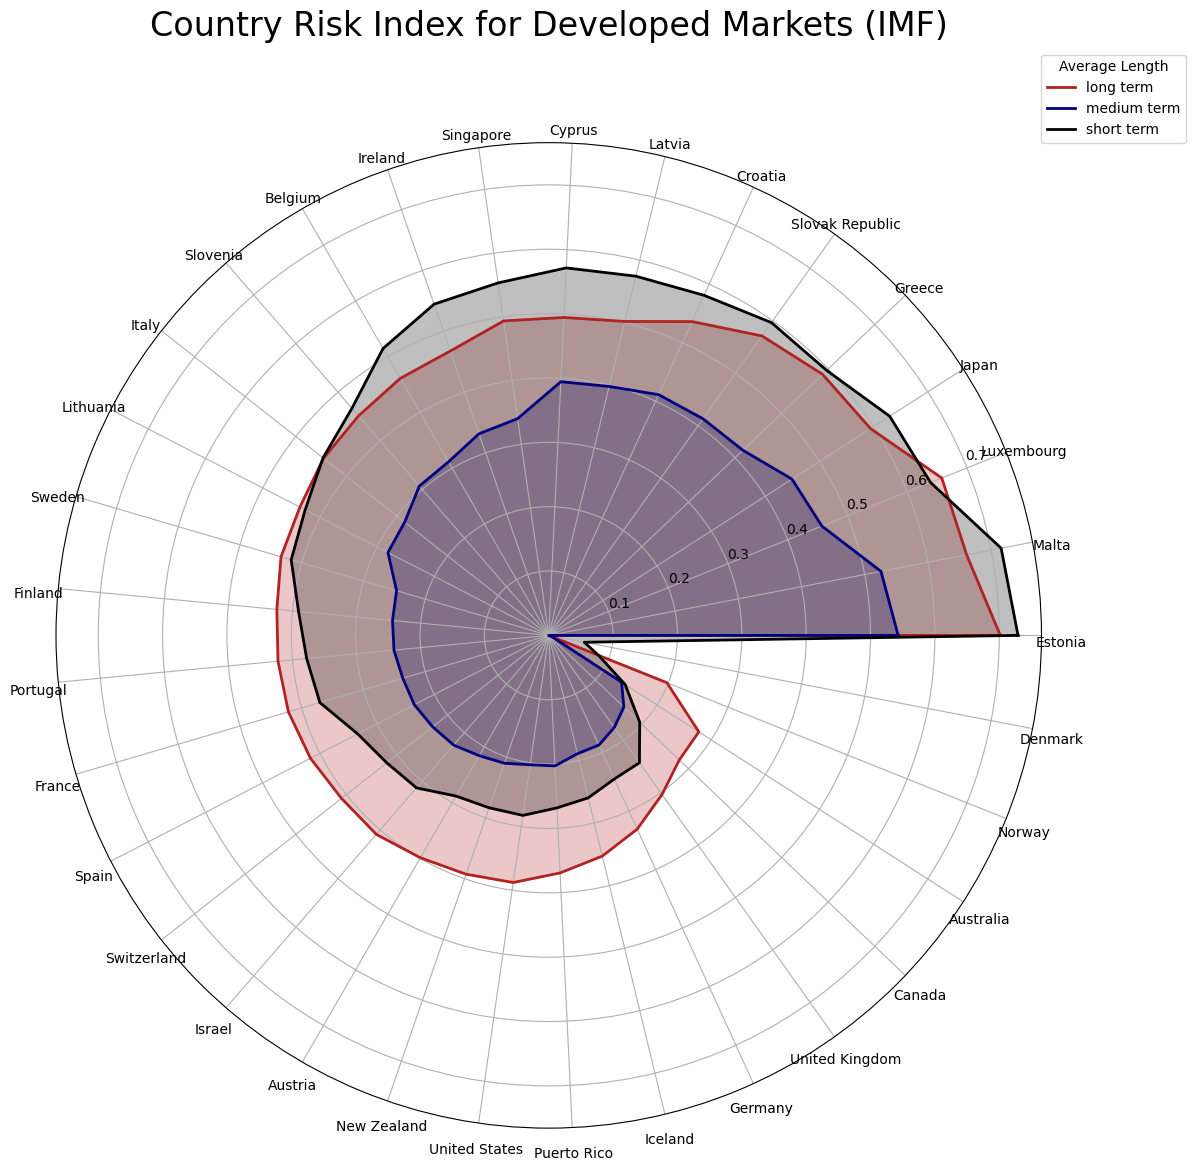

In [ ]:
# Create the figure and polar subplot
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

# Define the colors
colors = ['firebrick', 'navy', 'BLACK']

# Iterate over the DataFrames in CRI_am_dict with a counter for color selection
for i, (term, df) in enumerate(CRI_am_dict.items()):
    # Data for the chart
    categories = df.index
    values = df["CRI"]

    # Add the first value to the end to close the circle
    values = pd.concat([values, values.head(1)])  # Close the circle
    angles = np.linspace(0, 2 * np.pi, len(categories) + 1)

    # Plot the data with the specified color
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=term, color=colors[i % len(colors)])  # Add label for each term
    ax.fill(angles, values, alpha=0.25, color=colors[i % len(colors)])  # Optional: Fill under the lines

# Add category labels with more padding and rotation
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10, rotation=90, ha='center', va='top', rotation_mode='anchor')  # Increased padding

# Add a legend
ax.legend(title="Average Length", loc=(1, 1))

# Set the title with a larger font size
plt.title("Country Risk Index for Developed Markets (IMF)", fontsize=24 ,y=1.1)

# Adjust layout and padding
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


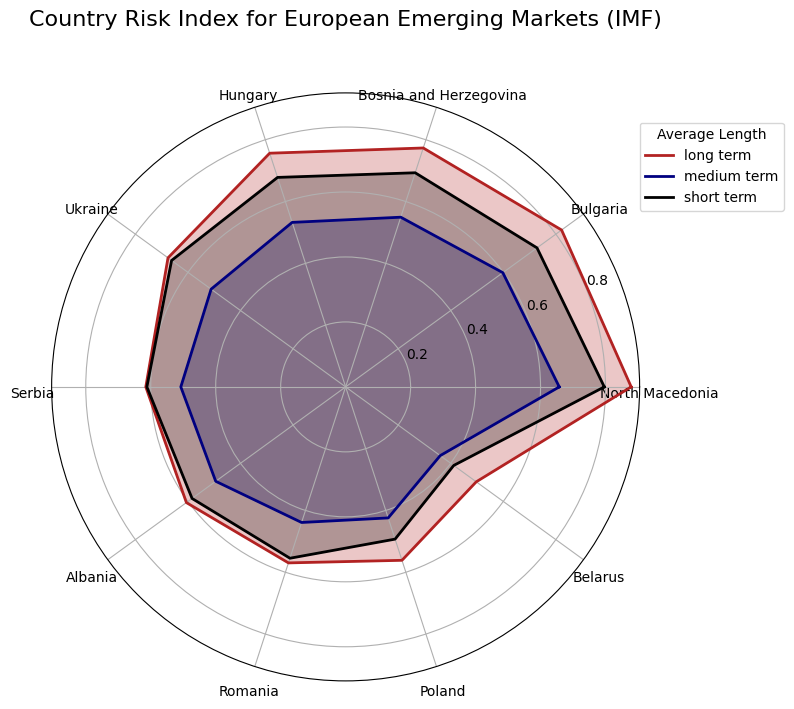

In [ ]:
# Create the figure and polar subplot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Define the colors
colors = ['firebrick', 'navy', 'BLACK']

# Iterate over the DataFrames in CRI_am_dict with a counter for color selection
for i, (term, df) in enumerate(CRI_eme_dict.items()):
    # Data for the chart
    categories = df.index
    values = df["CRI"]

    # Add the first value to the end to close the circle
    values = pd.concat([values, values.head(1)])  # Close the circle
    angles = np.linspace(0, 2 * np.pi, len(categories) + 1)

    # Plot the data with the specified color
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=term, color=colors[i % len(colors)])  # Add label for each term
    ax.fill(angles, values, alpha=0.25, color=colors[i % len(colors)])  # Optional: Fill under the lines

# Add category labels with more padding and rotation
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10, rotation=90, ha='center', va='top', rotation_mode='anchor')  # Increased padding

# Add a legend
ax.legend(title="Average Length", loc=(1, 0.8))

# Set the title with a larger font size
plt.title("Country Risk Index for European Emerging Markets (IMF)", fontsize=16,y=1.1)

# Adjust layout and padding
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


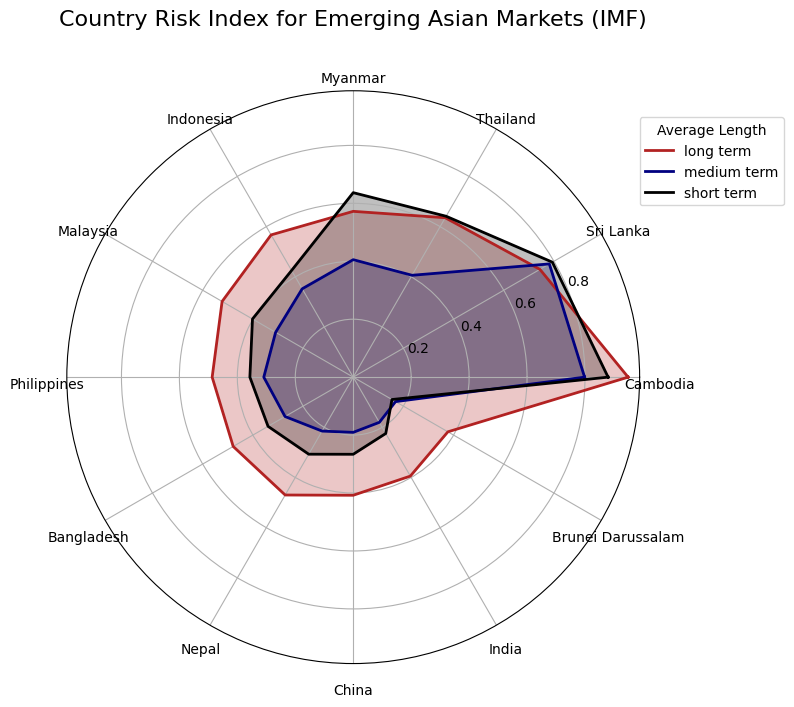

In [ ]:
# Create the figure and polar subplot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Define the colors
colors = ['firebrick', 'navy', 'BLACK']

# Iterate over the DataFrames in CRI_am_dict with a counter for color selection
for i, (term, df) in enumerate(CRI_ema_dict.items()):
    # Data for the chart
    categories = df.index
    values = df["CRI"]

    # Add the first value to the end to close the circle
    values = pd.concat([values, values.head(1)])  # Close the circle
    angles = np.linspace(0, 2 * np.pi, len(categories) + 1)

    # Plot the data with the specified color
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=term, color=colors[i % len(colors)])  # Add label for each term
    ax.fill(angles, values, alpha=0.25, color=colors[i % len(colors)])  # Optional: Fill under the lines

# Add category labels with more padding and rotation
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10, rotation=90, ha='center', va='top', rotation_mode='anchor')  # Increased padding

# Add a legend
ax.legend(title="Average Length", loc=(1, 0.8))

# Set the title with a larger font size
plt.title("Country Risk Index for Emerging Asian Markets (IMF)", fontsize=16,y=1.1)

# Adjust layout and padding
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


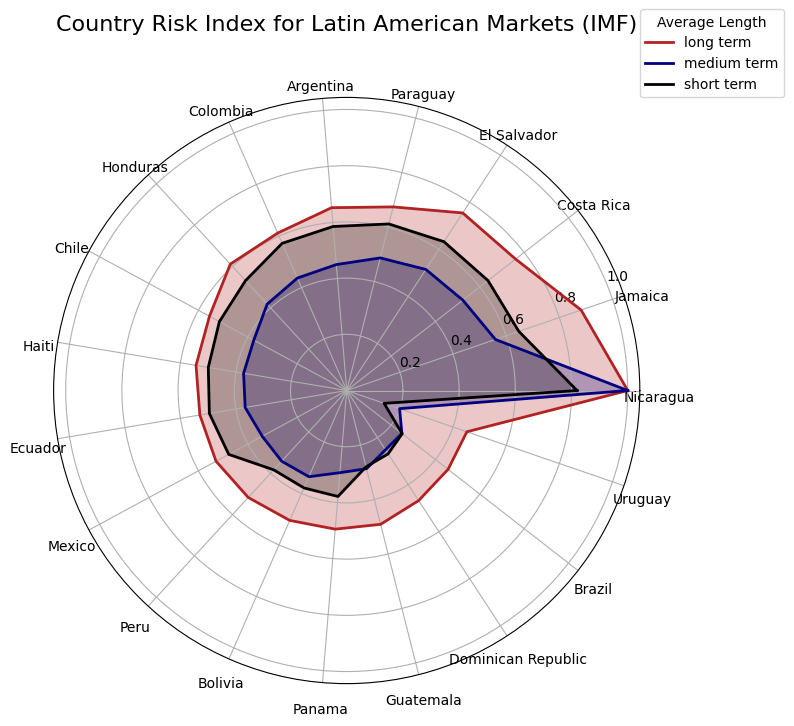

In [ ]:
# Create the figure and polar subplot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Define the colors
colors = ['firebrick', 'navy', 'BLACK']

# Iterate over the DataFrames in CRI_am_dict with a counter for color selection
for i, (term, df) in enumerate(CRI_latam_dict.items()):
    # Data for the chart
    categories = df.index
    values = df["CRI"]

    # Add the first value to the end to close the circle
    values = pd.concat([values, values.head(1)])  # Close the circle
    angles = np.linspace(0, 2 * np.pi, len(categories) + 1)

    # Plot the data with the specified color
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=term, color=colors[i % len(colors)])  # Add label for each term
    ax.fill(angles, values, alpha=0.25, color=colors[i % len(colors)])  # Optional: Fill under the lines

# Add category labels with more padding and rotation
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10, rotation=90, ha='center', va='top', rotation_mode='anchor')  # Increased padding

# Add a legend
ax.legend(title="Average Length", loc=(1, 1))

# Set the title with a larger font size
plt.title("Country Risk Index for Latin American Markets (IMF)", fontsize=16,y=1.1)

# Adjust layout and padding
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


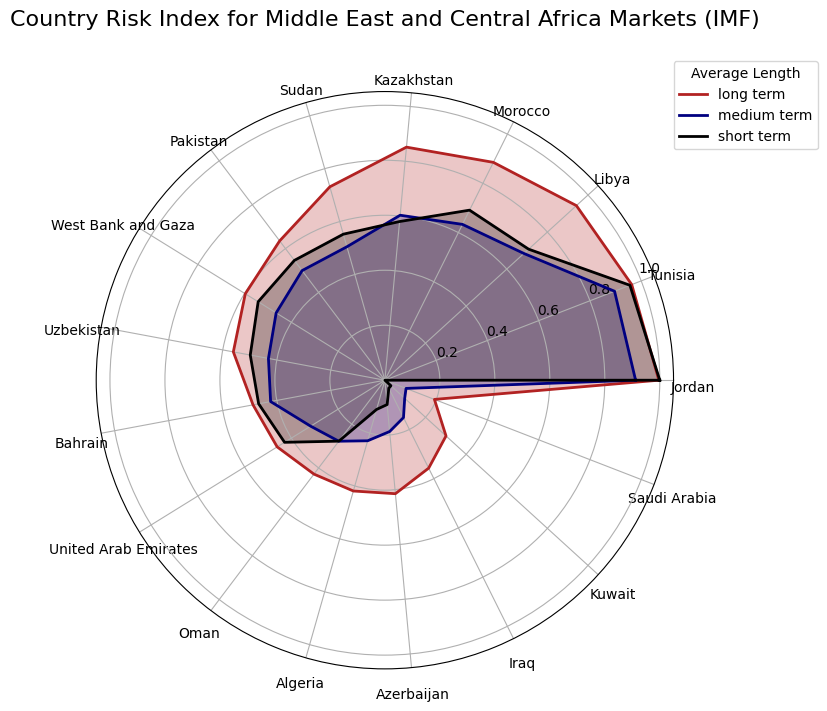

In [ ]:
# Create the figure and polar subplot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Define the colors
colors = ['firebrick', 'navy', 'BLACK']

# Iterate over the DataFrames in CRI_am_dict with a counter for color selection
for i, (term, df) in enumerate(CRI_meca_dict.items()):
    # Data for the chart
    categories = df.index
    values = df["CRI"]

    # Add the first value to the end to close the circle
    values = pd.concat([values, values.head(1)])  # Close the circle
    angles = np.linspace(0, 2 * np.pi, len(categories) + 1)

    # Plot the data with the specified color
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=term, color=colors[i % len(colors)])  # Add label for each term
    ax.fill(angles, values, alpha=0.25, color=colors[i % len(colors)])  # Optional: Fill under the lines

# Add category labels with more padding and rotation
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10, rotation=90, ha='center', va='top', rotation_mode='anchor')  # Increased padding

# Add a legend
ax.legend(title="Average Length", loc=(1, 0.9))

# Set the title with a larger font size
plt.title("Country Risk Index for Middle East and Central Africa Markets (IMF)", fontsize=16,y=1.1)

# Adjust layout and padding
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


### MSCI classification

In [ ]:
country_to_get = gc.open('data').worksheet('countries')
df_countries = pd.DataFrame(country_to_get.get_all_records())

em = df_countries['emerging markets'].drop_duplicates()
dm = df_countries['developed markets'].drop_duplicates()

In [ ]:
# Initialize empty dictionaries to store the aggregated DataFrames for each aggregate category
CRI_em_dict = {}
CRI_dm_dict = {}

# Define the aggregate mapping
aggregate_mapping = {
    'dm': dm,
    'em': em,
}

# Iterate over each term's DataFrame in the CRI_country_rank_dict
for term, df in CRI_country_rank_dict.items():
    # Adding the aggregation group to perform a per group analysis
    df['Aggregate'] = ''

    # Assign aggregate labels based on country membership
    for aggregate_label, country_list in aggregate_mapping.items():
        df.loc[df.index.isin(country_list), 'Aggregate'] = aggregate_label

    # Add the weights calculated as wi = GDPi / sum(GDPs)
    df['gdp weight'] = filtered_weights_df['2022']
    df['weighted CRI'] = df['gdp weight'] * df['CRI']

    # Create separate dictionaries for each aggregate
    for aggregate_label in aggregate_mapping.keys():
        aggregate_df = df[df['Aggregate'] == aggregate_label].drop(['gdp weight', 'Aggregate'], axis=1)

        # Store in the corresponding dictionary
        if aggregate_label == 'dm':
            CRI_dm_dict[term] = aggregate_df
        elif aggregate_label == 'em':
            CRI_em_dict[term] = aggregate_df

In [ ]:
CRI_em_dict

{'long term':                            CRI  CRI order weighted CRI
 Country Name                                          
 Argentina                  1.0          1     0.007017
 Tunisia               0.962957          3     0.000478
 Ukraine               0.756471         13     0.001363
 Jamaica               0.754715         14     0.000144
 Sri Lanka             0.744152         15     0.000613
 Kazakhstan            0.731403         16      0.00183
 Estonia               0.701643         17     0.000296
 Serbia                0.675912         18     0.000478
 Malta                 0.661285         20     0.000135
 Peru                  0.652798         22     0.001786
 Thailand              0.635387         23     0.003504
 Romania               0.615205         25     0.002045
 Bulgaria              0.605924         28     0.000608
 Morocco               0.597212         29      0.00087
 Latvia                0.594329         30     0.000267
 Malaysia              0.572361    

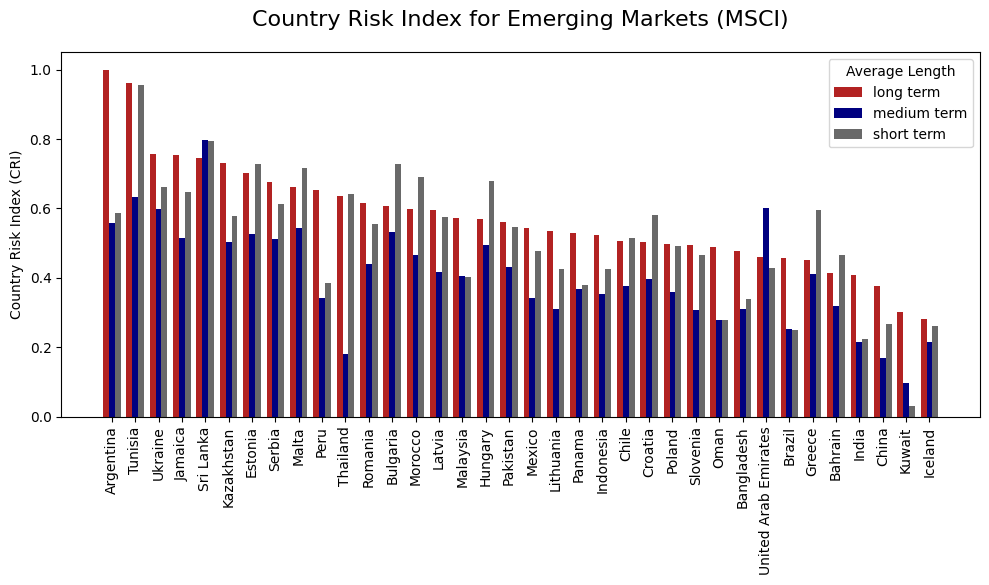

In [ ]:

# Define the colors for each term
colors = ['firebrick', 'navy', 'dimgray']

# Use the long-term DataFrame to get the index (countries)
categories = CRI_em_dict['long term'].index
num_categories = len(categories)
num_terms = len(CRI_em_dict)

# Set the positions and width for the bars
x = np.arange(num_categories)
width = 0.25  # Width of each bar

# Create the figure and axis for the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over terms to plot each bar group
for i, (term, df) in enumerate(CRI_em_dict.items()):
    # Reindex the values to match the categories
    values = df.reindex(categories)['CRI']
    ax.bar(x + i * width, values, width=width, label=term, color=colors[i % len(colors)])

# Add category (country) labels to x-axis
ax.set_xticks(x + width * (num_terms - 1) / 2)
ax.set_xticklabels(categories, rotation=90, ha='center')

# Set labels and title
ax.set_ylabel("Country Risk Index (CRI)")
ax.set_title("Country Risk Index for Emerging Markets (MSCI)", fontsize=16, y=1.05)

# Add a legend with adjusted title
ax.legend(title="Average Length", loc='upper right')

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


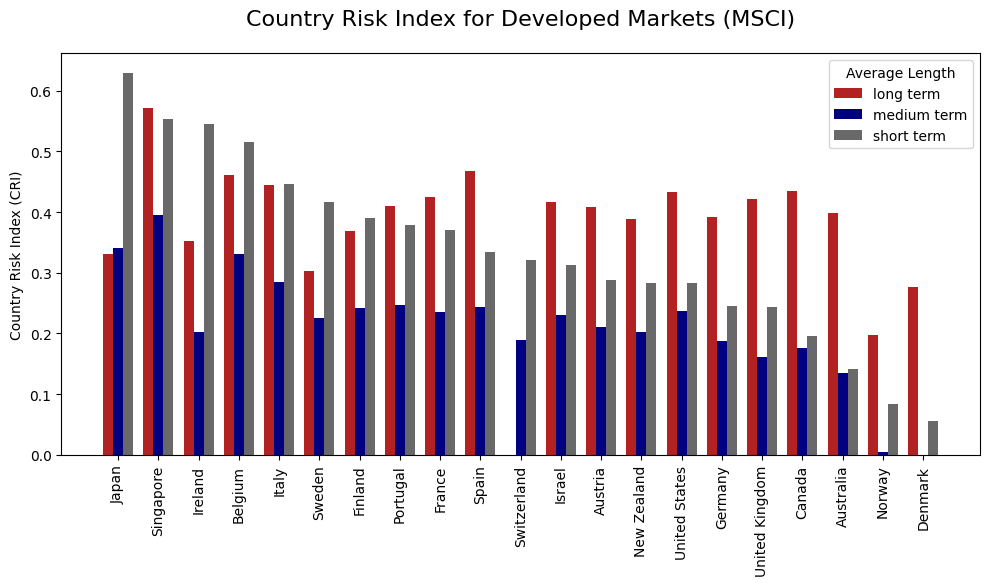

In [ ]:

# Define the colors for each term
colors = ['firebrick', 'navy', 'dimgray']

# Use the first DataFrame (short-term) to get the index (countries)
categories = CRI_dm_dict['short term'].index
num_categories = len(categories)
num_terms = len(CRI_dm_dict)

# Set the positions and width for the bars
x = np.arange(num_categories)
width = 0.25  # Width of each bar

# Create the figure and axis for the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over terms to plot each bar group
for i, (term, df) in enumerate(CRI_dm_dict.items()):
    # Ensure values align with categories by reindexing
    values = df.reindex(categories)['CRI']  # Reindex to match categories
    ax.bar(x + i * width, values, width=width, label=term, color=colors[i % len(colors)])

# Add category (country) labels to x-axis
ax.set_xticks(x + width * (num_terms - 1) / 2)
ax.set_xticklabels(categories, rotation=90, ha='center')

# Set labels and title
ax.set_ylabel("Country Risk Index (CRI)")
ax.set_title("Country Risk Index for Developed Markets (MSCI)", fontsize=16, y=1.05)

# Add a legend with adjusted title
ax.legend(title="Average Length", loc='upper right')

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


### Bonds Spread and CRI Correlation

In [ ]:
#it can be interesting to look at bonds spread vs us for the period of reference and see if this CRI index is correlated :)

In [ ]:
spread = gc.open('data').worksheet('spreads')
bs_df = pd.DataFrame(spread.get_all_records())

In [ ]:
bs_df

Country  2022 Yield (%)  Spread vs. U.S. Treasury (%) Category
0   United States            3.88                          0.00       dm
1     Switzerland            1.56                         -2.32       dm
2          Norway            3.17                         -0.71       dm
3          Sweden            2.44                         -1.44       dm
4         Denmark            1.92                         -1.96       dm
..            ...             ...                           ...      ...
76        Algeria            7.00                          3.12       em
77       Pakistan           11.60                          7.72       em
78           Iraq            7.00                          3.12       em
79          Sudan           12.50                          8.62       em
80          Libya            8.00                          4.12       em

[81 rows x 4 columns]

Eliminating not matching countries in the two datasets

In [ ]:
spread_names = []
for name in bs_df['Country']:
  spread_names.append(name)

cri_names = []
for name in CRI_country_rank_aggregated_dict['long term'].index:
  cri_names.append(name)

missing_names = list(set(cri_names) - set(spread_names))
outliers_names = ['Argentina','Lybia']
missing_names = missing_names + outliers_names

In [ ]:
missing_names

['Guatemala',
 'Honduras',
 'Ecuador',
 'Panama',
 'Jamaica',
 'United Arab Emirates',
 'Bosnia and Herzegovina',
 'Costa Rica',
 'West Bank and Gaza',
 'Haiti',
 'Nicaragua',
 'Brunei Darussalam',
 'Argentina',
 'Lybia']

In [ ]:
#removing from cri data countries that have not data about spreads
cri_all_country = {}
for key, value in CRI_country_rank_aggregated_dict.items():
    if isinstance(value, pd.DataFrame):
        # Drop rows where the index is in missing_names
        filtered_df = value[~value.index.isin(missing_names)]
        cri_all_country[key] = filtered_df

# removing from bs coutnries that are not in cri dataset
ctry_in_cri = []
for key, value in cri_all_country.items():
  ctry_in_cri.append(value.index)

bs_df = bs_df[bs_df['Country'].isin(ctry_in_cri[0])]


In [ ]:
print(f'number of countries in bonds spread data {len(bs_df["Country"])} while in the CRI data is {len(cri_all_country["long term"].index)}')

number of countries in bonds spread data 78 while in the CRI data is 78


In [ ]:
for term in ['long term', 'medium term', 'short term']:
    # Merge '2022 Yield (%)' into the corresponding DataFrame in cri_all_country
    cri_all_country[term] = cri_all_country[term].merge(
        bs_df[['Country', '2022 Yield (%)', 'Category']],
        left_index=True,
        right_on='Country',
        how='left'
    ).set_index('Country')  # Set 'Country' as the index after merging

In [ ]:
cri_all_country

{'long term':                   CRI  CRI order weighted CRI  2022 Yield (%) Category
 Country                                                               
 Sudan        0.996588          2     0.000573           12.50       em
 Tunisia      0.962957          3     0.000478            9.00       em
 Cambodia       0.9489          4     0.000311            4.80       em
 Libya        0.942663          5     0.000586            8.00       em
 Jordan       0.885246          6     0.000479            3.68       em
 ...               ...        ...          ...             ...      ...
 Iceland      0.280328         87     0.000089            7.35       dm
 Denmark      0.277229         88     0.001233            1.92       dm
 Norway       0.197705         89     0.001306            3.17       dm
 Azerbaijan   0.193304         90     0.000169            6.98       em
 Switzerland       0.0         91          0.0            1.56       dm
 
 [78 rows x 5 columns],
 'medium term':          

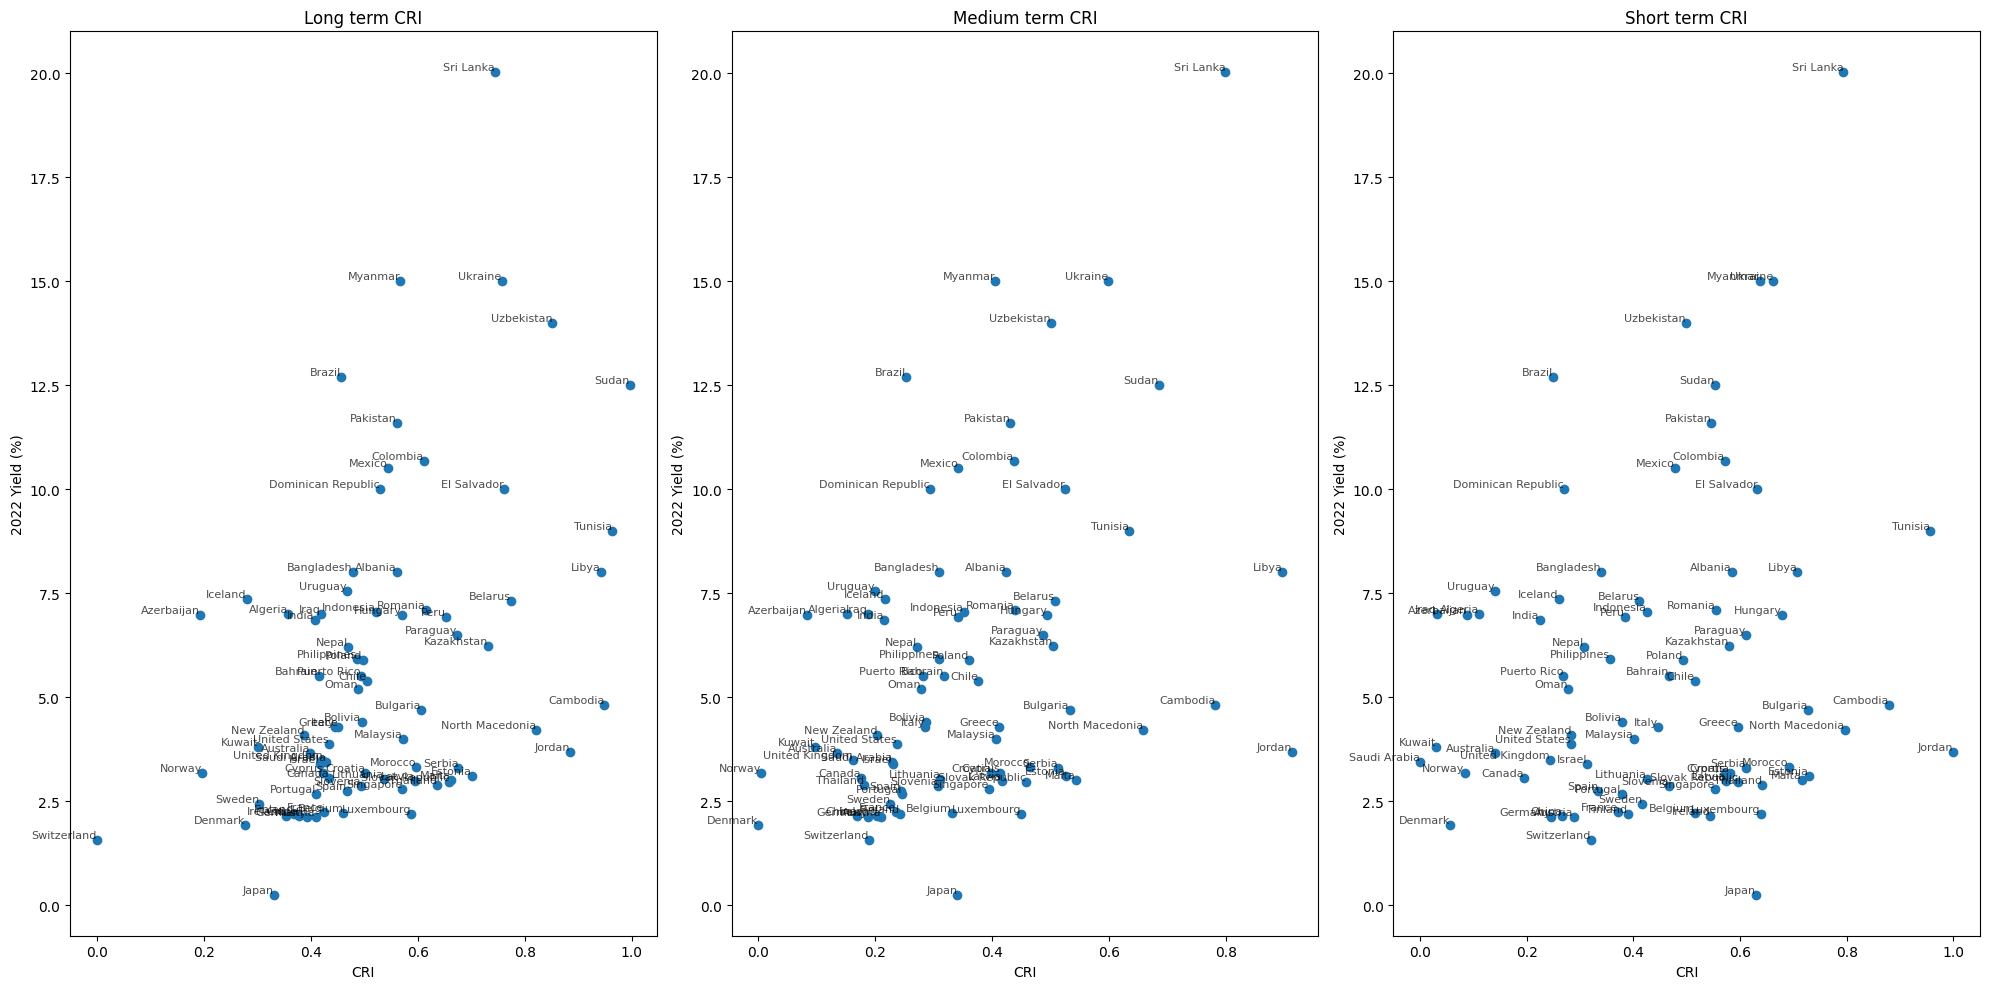

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

# Scatter plots with country labels
for i, term in enumerate(['long term', 'medium term', 'short term']):
    # Plot scatter points
    ax[i].scatter(cri_all_country[term]['CRI'], cri_all_country[term]['2022 Yield (%)'])
    ax[i].set_title(f'{term.capitalize()} CRI')
    ax[i].set_xlabel('CRI')
    ax[i].set_ylabel('2022 Yield (%)')

    # Add country labels for each point
    for country, (x, y) in cri_all_country[term][['CRI', '2022 Yield (%)']].iterrows():
        ax[i].text(x, y, country, fontsize=8, ha='right', va='bottom', alpha=0.7)

plt.tight_layout()
plt.show()


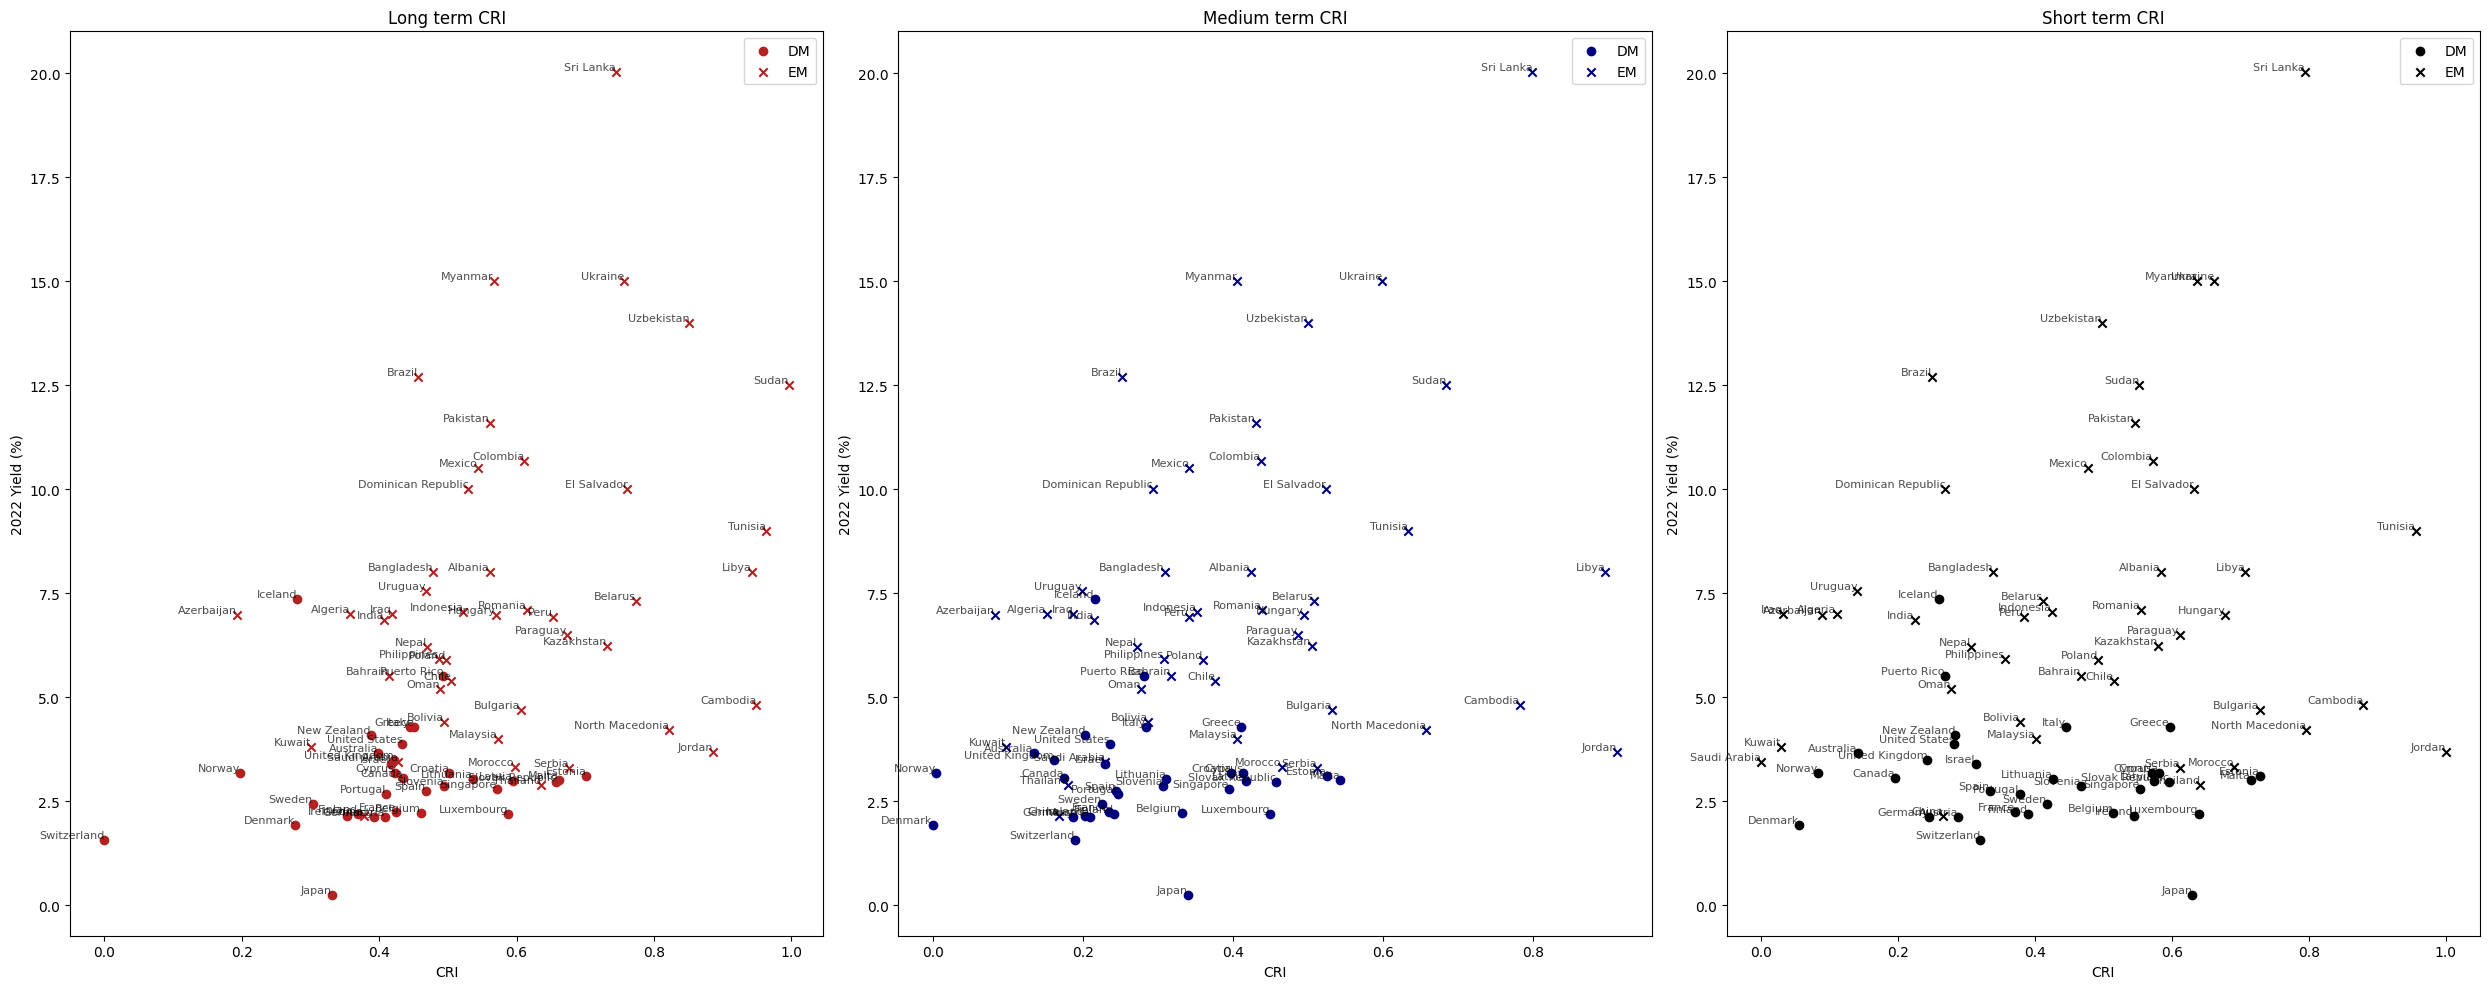

In [ ]:
colors = ['firebrick', 'navy', 'black']
fig, ax = plt.subplots(1, 3, figsize=(25, 10))

# Scatter plots with country labels and symbols based on Category
for i, (term, color) in enumerate(zip(['long term', 'medium term', 'short term'], colors)):
    # Separate data based on Category
    dm_data = cri_all_country[term][cri_all_country[term]['Category'] == 'dm']
    em_data = cri_all_country[term][cri_all_country[term]['Category'] == 'em']

    # Plot 'dm' as 'o' and 'em' as 'x'
    ax[i].scatter(dm_data['CRI'], dm_data['2022 Yield (%)'], color=color, marker='o', label='DM')
    ax[i].scatter(em_data['CRI'], em_data['2022 Yield (%)'], color=color, marker='x', label='EM')

    # Set title, labels, and legend
    ax[i].set_title(f'{term.capitalize()} CRI')
    ax[i].set_xlabel('CRI')
    ax[i].set_ylabel('2022 Yield (%)')
    ax[i].legend()

    # Add country labels for each point
    for country, (x, y) in cri_all_country[term][['CRI', '2022 Yield (%)']].iterrows():
        ax[i].text(x, y, country, fontsize=8, ha='right', va='bottom', alpha=0.7)

plt.tight_layout()
plt.show()


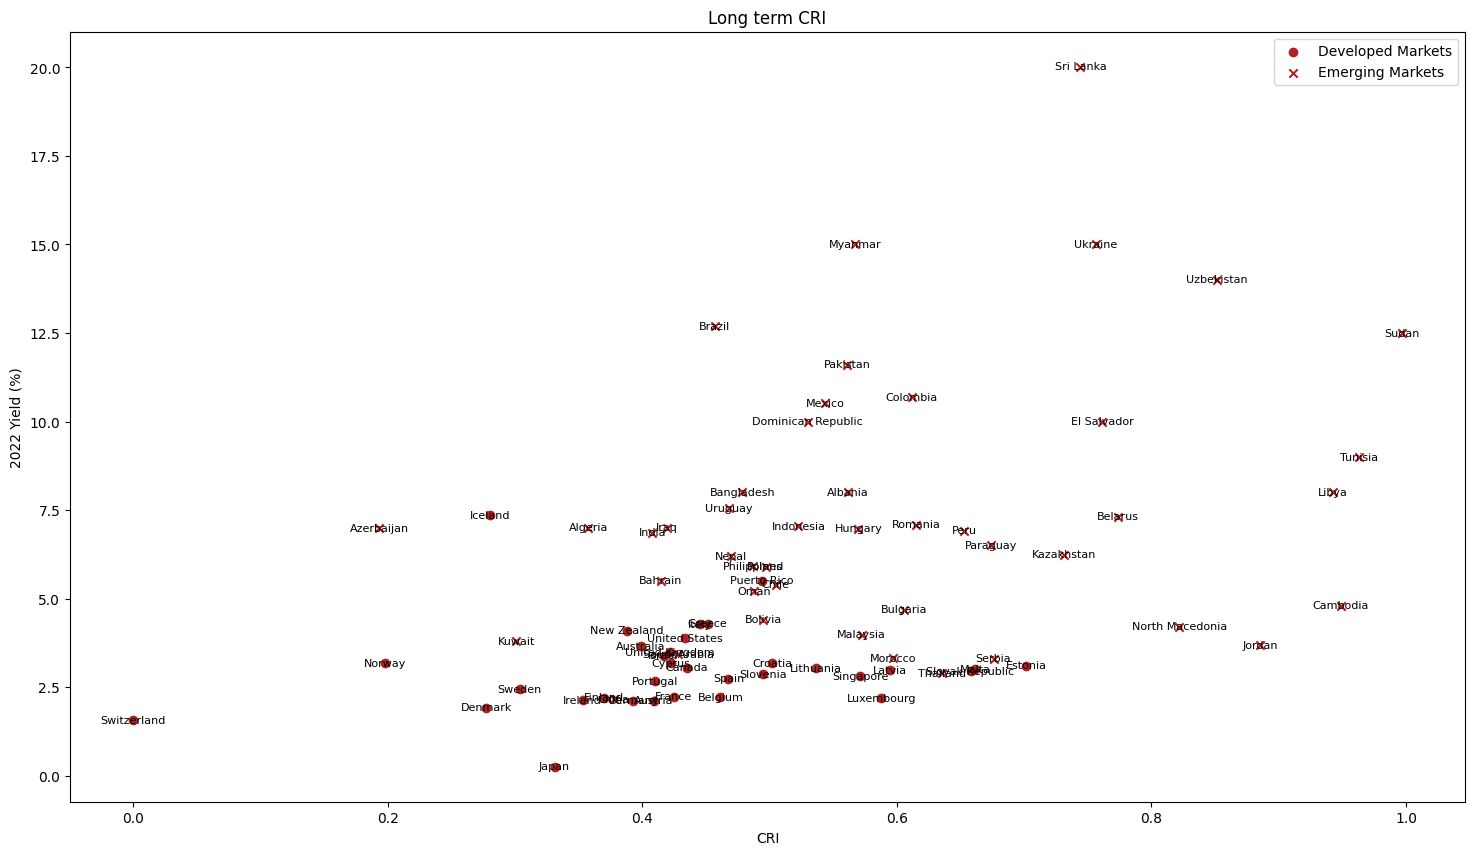

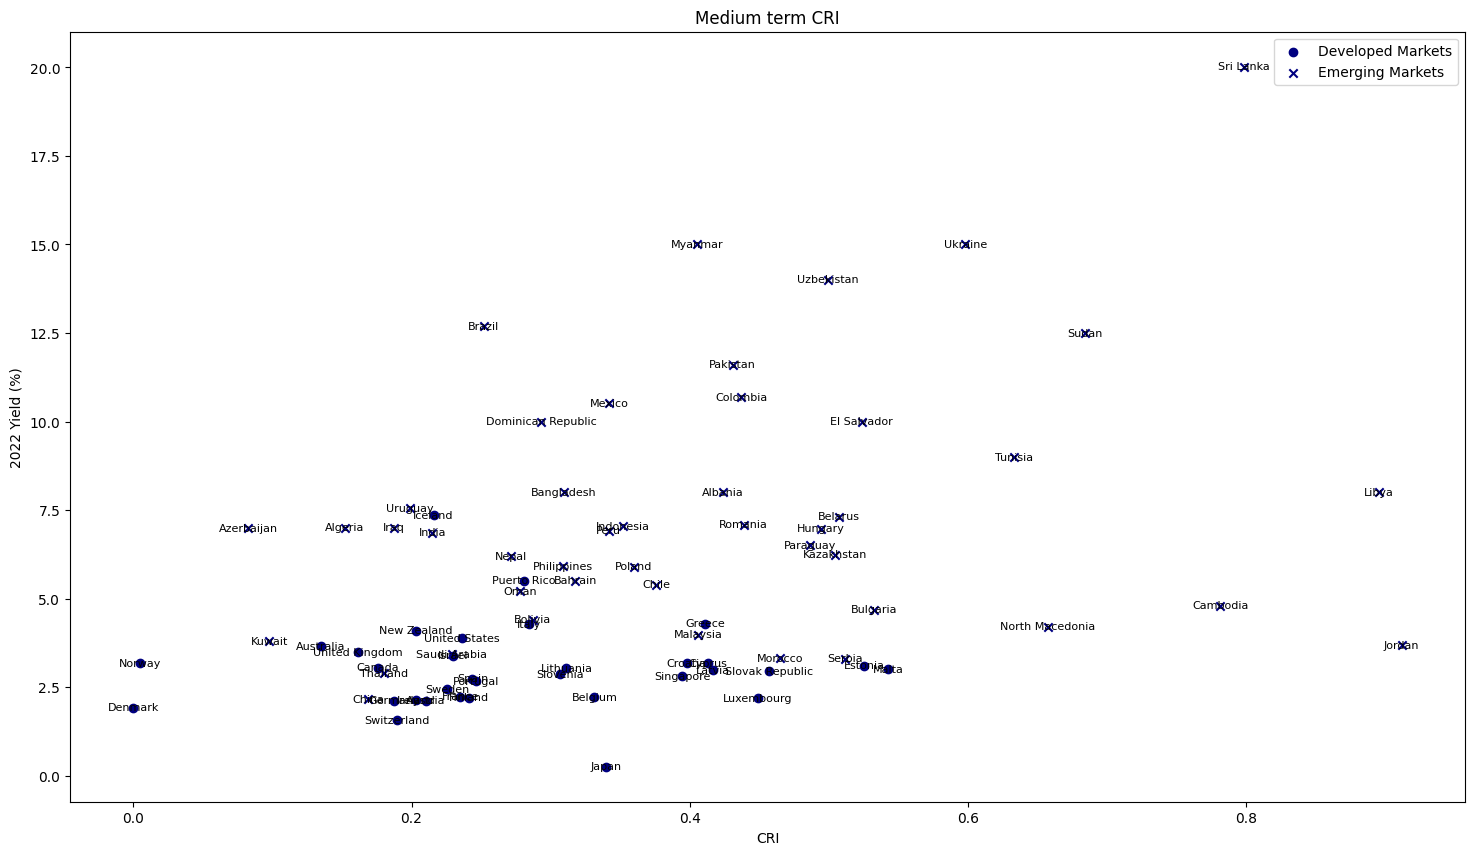

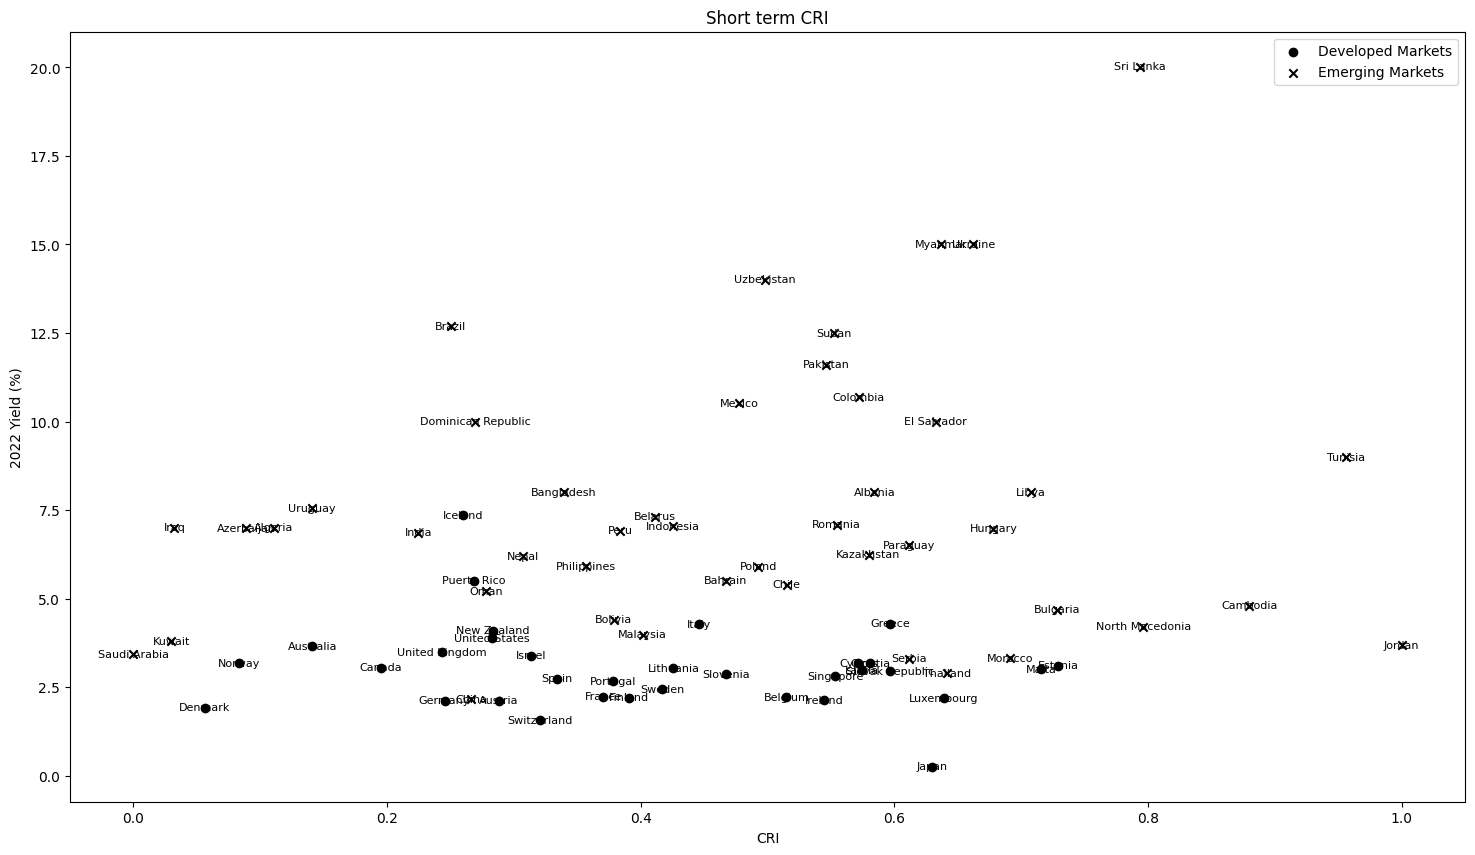

In [ ]:

colors = ['firebrick', 'navy', 'black']

for i, (term, color) in enumerate(zip(['long term', 'medium term', 'short term'], colors)):
    # Separate data based on Category
    dm_data = cri_all_country[term][cri_all_country[term]['Category'] == 'dm']
    em_data = cri_all_country[term][cri_all_country[term]['Category'] == 'em']

    # Create a new figure for each plot
    plt.figure(figsize=(18, 10))

    # Plot 'dm' as 'o' and 'em' as 'x'
    plt.scatter(dm_data['CRI'], dm_data['2022 Yield (%)'], color=color, marker='o', label='Developed Markets')
    plt.scatter(em_data['CRI'], em_data['2022 Yield (%)'], color=color, marker='x', label='Emerging Markets')

    # Set title, labels, and legend
    plt.title(f'{term.capitalize()} CRI')
    plt.xlabel('CRI')
    plt.ylabel('2022 Yield (%)')
    plt.legend()

    # Add country labels for each point
    for country, (x, y) in cri_all_country[term][['CRI', '2022 Yield (%)']].iterrows():
        plt.text(x, y, country, fontsize=8, ha='center', va='center')

    # Show the plot
    plt.show()

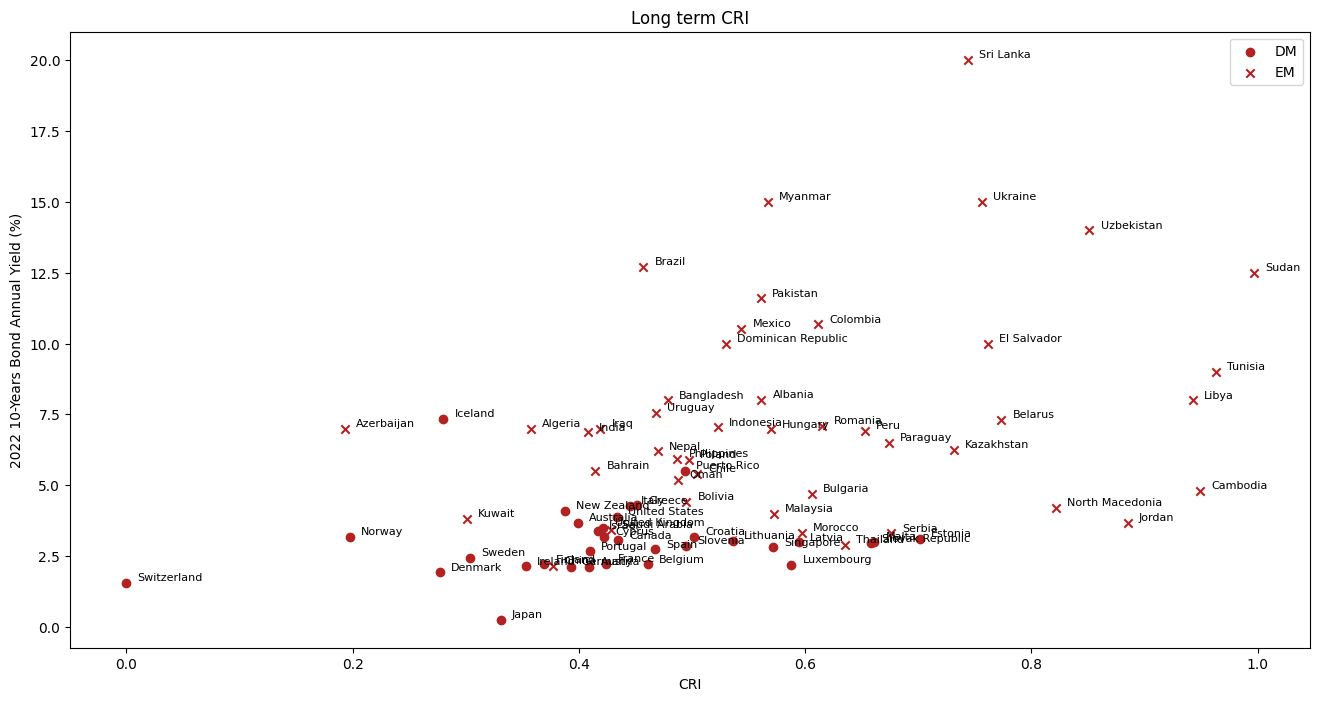

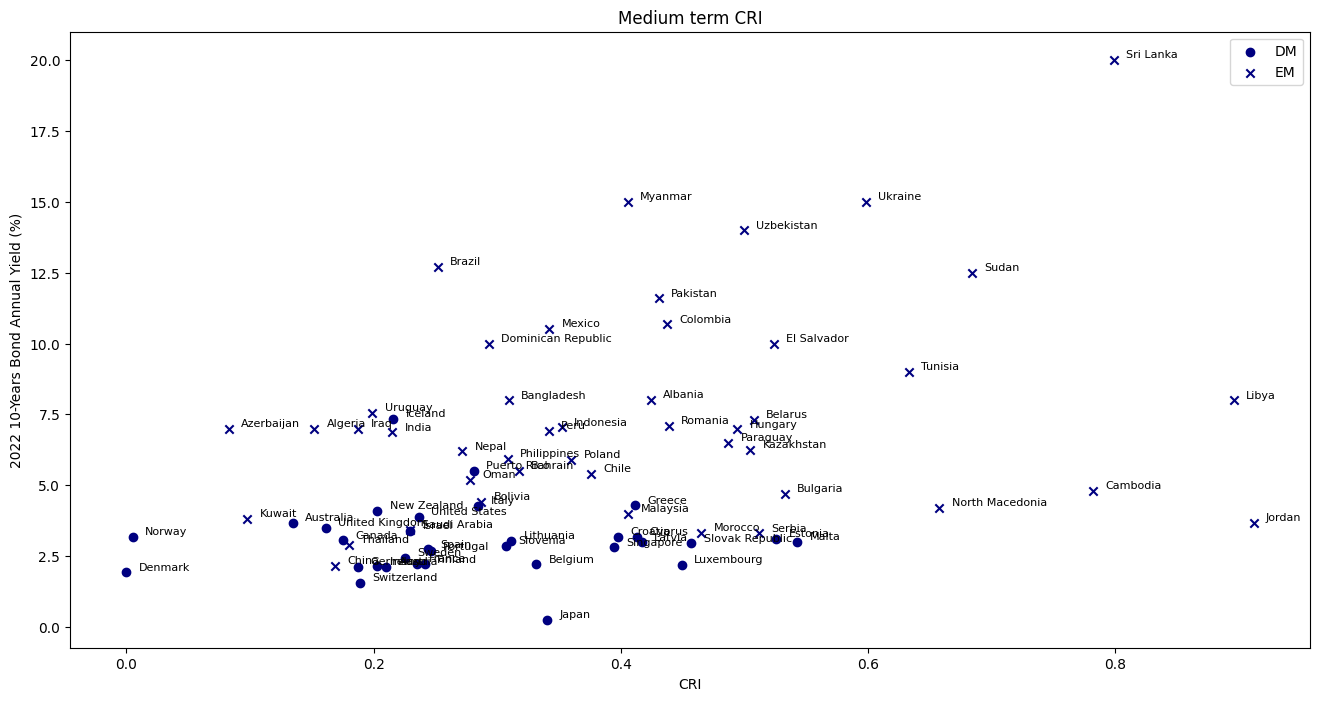

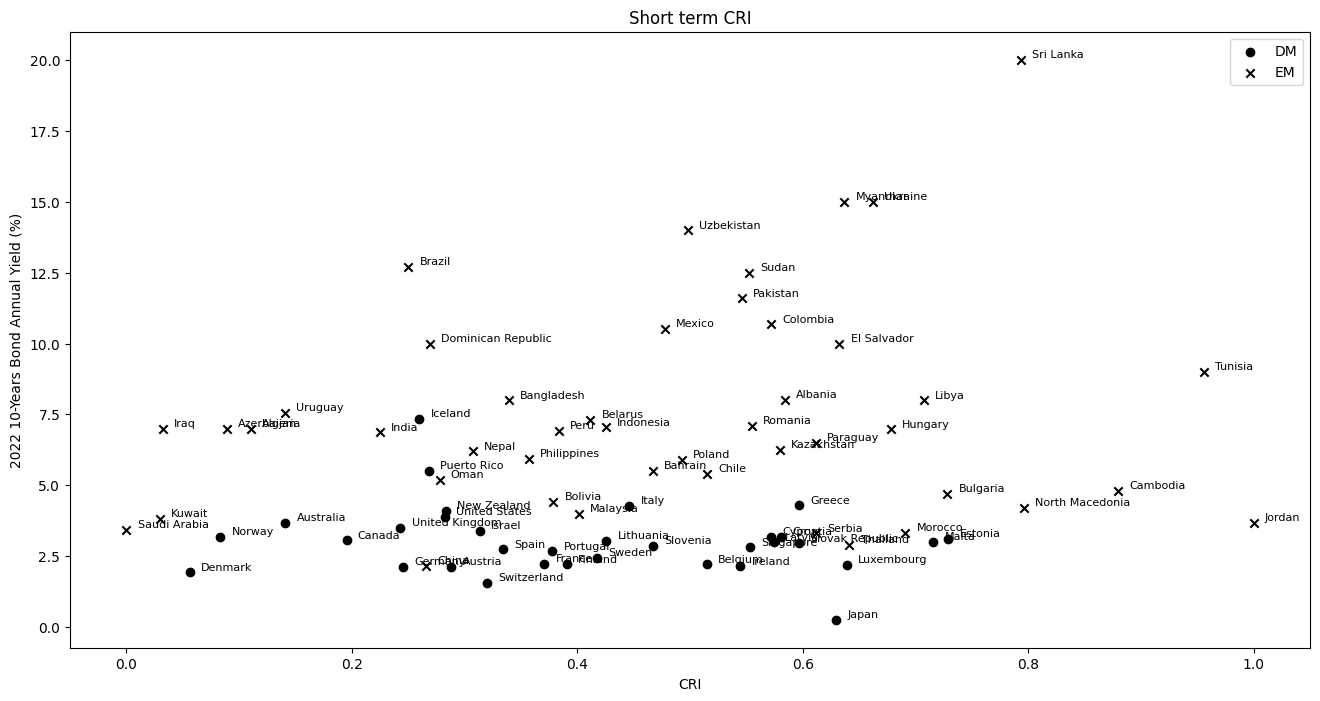

In [ ]:
import matplotlib.pyplot as plt

colors = ['firebrick', 'navy', 'black']

for i, (term, color) in enumerate(zip(['long term', 'medium term', 'short term'], colors)):
    # Separate data based on Category
    dm_data = cri_all_country[term][cri_all_country[term]['Category'] == 'dm']
    em_data = cri_all_country[term][cri_all_country[term]['Category'] == 'em']

    # Create a new figure for each plot
    plt.figure(figsize=(16, 8))

    # Plot 'dm' as 'o' and 'em' as 'x'
    plt.scatter(dm_data['CRI'], dm_data['2022 Yield (%)'], color=color, marker='o', label='DM')
    plt.scatter(em_data['CRI'], em_data['2022 Yield (%)'], color=color, marker='x', label='EM')

    # Set title, labels, and legend
    plt.title(f'{term.capitalize()} CRI')
    plt.xlabel('CRI')
    plt.ylabel('2022 10-Years Bond Annual Yield (%)')
    plt.legend()

    # Add country labels for each point with offset
    for country, (x, y) in cri_all_country[term][['CRI', '2022 Yield (%)']].iterrows():
        plt.text(x + 0.01, y + 0.01, country, fontsize=8, ha='left', va='bottom')  # Adjusted

    # Show the plot
    plt.show()

### Regression

#### Bond Yield - CRI: Univariate Regression

In [ ]:
cri_all_country

{'long term':                   CRI  CRI order weighted CRI  2022 Yield (%) Category
 Country                                                               
 Sudan        0.996588          2     0.000573           12.50       em
 Tunisia      0.962957          3     0.000478            9.00       em
 Cambodia       0.9489          4     0.000311            4.80       em
 Libya        0.942663          5     0.000586            8.00       em
 Jordan       0.885246          6     0.000479            3.68       em
 ...               ...        ...          ...             ...      ...
 Iceland      0.280328         87     0.000089            7.35       dm
 Denmark      0.277229         88     0.001233            1.92       dm
 Norway       0.197705         89     0.001306            3.17       dm
 Azerbaijan   0.193304         90     0.000169            6.98       em
 Switzerland       0.0         91          0.0            1.56       dm
 
 [78 rows x 5 columns],
 'medium term':          

In [ ]:
#LINEAR REGRESSION!

import statsmodels.api as sm

# Extract DataFrames from the dictionary
lt_df = cri_all_country['long term']
mt_df = cri_all_country['medium term']
st_df = cri_all_country['short term']

# Function to perform regression and print results
def run_regression(df, term_name):
    # Ensure 'CRI' and '2022 yield (%)' are numeric, coerce errors to NaN and then drop them
    df['CRI'] = pd.to_numeric(df['CRI'], errors='coerce')
    df['2022 Yield (%)'] = pd.to_numeric(df['2022 Yield (%)'], errors='coerce')
    df = df.dropna(subset=['CRI', '2022 Yield (%)'])

    # Separate independent and dependent variables
    X = df['CRI']
    y = df['2022 Yield (%)']

    # Add a constant (intercept) to the model
    X = sm.add_constant(X)

    # Run the regression
    model = sm.OLS(y, X).fit()

    # Print the results
    print(f"\nRegression results for {term_name}:")
    print(model.summary())
    return model

# Run regression for each term
lt_model = run_regression(lt_df, 'Long Term')
mt_model = run_regression(mt_df, 'Medium Term')
st_model = run_regression(st_df, 'Short Term')




Regression results for Long Term:
                            OLS Regression Results                            
Dep. Variable:         2022 Yield (%)   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     17.35
Date:                Sat, 30 Nov 2024   Prob (F-statistic):           8.12e-05
Time:                        08:25:57   Log-Likelihood:                -203.87
No. Observations:                  78   AIC:                             411.7
Df Residuals:                      76   BIC:                             416.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.

In [ ]:
# QUADRATIC REGRESSION

import pandas as pd
import statsmodels.api as sm

# Extract DataFrames from the dictionary
lt_df = cri_all_country['long term']
mt_df = cri_all_country['medium term']
st_df = cri_all_country['short term']

# Function to perform quadratic regression and print results
def run_quadratic_regression(df, term_name):
    # Ensure 'CRI' and '2022 yield (%)' are numeric, coerce errors to NaN and then drop them
    df['CRI'] = pd.to_numeric(df['CRI'], errors='coerce')
    df['2022 Yield (%)'] = pd.to_numeric(df['2022 Yield (%)'], errors='coerce')
    df = df.dropna(subset=['CRI', '2022 Yield (%)'])

    # Separate independent and dependent variables
    X = df[['CRI']]
    X['CRI^2'] = X['CRI'] ** 2  # Add quadratic term
    y = df['2022 Yield (%)']

    # Add a constant (intercept) to the model
    X = sm.add_constant(X)

    # Run the regression
    model = sm.OLS(y, X).fit()

    # Print the results
    print(f"\nQuadratic regression results for {term_name}:")
    print(model.summary())
    return model

# Run quadratic regression for each term
lt_model = run_quadratic_regression(lt_df, 'Long Term')
mt_model = run_quadratic_regression(mt_df, 'Medium Term')
st_model = run_quadratic_regression(st_df, 'Short Term')



Quadratic regression results for Long Term:
                            OLS Regression Results                            
Dep. Variable:         2022 Yield (%)   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     8.578
Date:                Sat, 30 Nov 2024   Prob (F-statistic):           0.000442
Time:                        08:25:57   Log-Likelihood:                -203.86
No. Observations:                  78   AIC:                             413.7
Df Residuals:                      75   BIC:                             420.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

<ipython-input-154-93d26cac54b4>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['CRI^2'] = X['CRI'] ** 2  # Add quadratic term
<ipython-input-154-93d26cac54b4>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['CRI^2'] = X['CRI'] ** 2  # Add quadratic term
<ipython-input-154-93d26cac54b4>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

#### Bond Yield - K Variables: Multivariate Regression

In [ ]:
spread = gc.open('data').worksheet('spreads')
bs_df = pd.DataFrame(spread.get_all_records())

In [ ]:
X_lt = cri_df_dict['long term']
X_mt = cri_df_dict['medium term']
X_st = cri_df_dict['short term']

lon gterm = delta - avg(n=10)
medium and short 5 and 3

In [ ]:
X_lt

inflation rates  gdp growth rates  exchange rates  \
Country Name                                                              
Albania                      0.896393         -0.752084        0.010236   
United Arab Emirates         0.872893         -0.746221        0.045616   
Argentina                    0.902565         -0.000000        0.901704   
Australia                    0.903675         -0.744052        0.056933   
Austria                      0.906047         -0.758041        0.042390   
...                               ...               ...             ...   
Tunisia                      0.894265         -0.754614        0.132564   
Ukraine                      0.887224         -0.728636        0.144351   
Uruguay                      0.891767         -0.756145        0.223955   
United States                0.923590         -0.749168        0.045616   
Uzbekistan                   0.891304         -0.744985        0.413171   

                      overall balance  gross debt  current account  openness  \
Country Name                                                                   
Albania                     -0.687107    0.340861        -0.328789  0.213706   
United Arab Emirates        -0.679050    0.372636        -0.392981  0.221495   
Argentina                   -0.682274    0.372636        -0.416182  0.075040   
Australia                   -0.695080    0.555681        -0.441172  0.109996   
Austria                     -0.692928    0.331767        -0.422304  0.313587   
...                               ...         ...              ...       ...   
Tunisia                     -0.687171    0.372636        -0.277129  0.295526   
Ukraine                     -0.686144    0.372636        -0.508642  0.219529   
Uruguay                     -0.687171    0.372636        -0.361756  0.145497   
United States               -0.692312    0.480308        -0.361551  0.063090   
Uzbekistan                  -0.440499    0.372636        -0.414211  0.176819   

                     governance  short term debt  long term debt       CRI  \
Country Name                                                                 
Albania                -0.49956         0.166334        0.551416 -0.088595   
United Arab Emirates  -0.686716         0.170248        0.432623 -0.389458   
Argentina             -0.439642         0.239831        0.270577  1.224256   
Australia             -0.923346         0.170248        0.432623 -0.574496   
Austria               -0.867527         0.170248        0.432623 -0.544138   
...                         ...              ...             ...       ...   
Tunisia               -0.418257         0.946798        0.608781  1.113398   
Ukraine               -0.297749         0.292997        0.799884  0.495451   
Uruguay               -0.799959         0.170248        0.432623 -0.368306   
United States         -0.783466         0.170248        0.432623 -0.471022   
Uzbekistan            -0.315769         0.234486        0.606696  0.779647   

                      CRI order  
Country Name                     
Albania                      36  
United Arab Emirates         59  
Argentina                     1  
Australia                    76  
Austria                      74  
...                         ...  
Tunisia                       3  
Ukraine                      13  
Uruguay                      56  
United States                65  
Uzbekistan                    9  

[91 rows x 12 columns]

In [ ]:
#reindex bs_df
bs_df = bs_df.set_index('Country')

# get common ountries between X_lt and bs_df to perform the merging
common_countries = X_lt.index.intersection(bs_df.index)

In [ ]:
#filter to keep only common countries
X_lt = X_lt[X_lt.index.isin(common_countries)]
bs_df = bs_df[bs_df.index.isin(common_countries)]
#merge dataframes
X_lt = X_lt.join(bs_df[['Category', '2022 Yield (%)']], how='left')


X_mt = X_mt[X_mt.index.isin(common_countries)]
bs_df = bs_df[bs_df.index.isin(common_countries)]
X_mt = X_mt.join(bs_df[['Category', '2022 Yield (%)']], how='left')

X_st = X_st[X_st.index.isin(common_countries)]
bs_df = bs_df[bs_df.index.isin(common_countries)]
X_st = X_st.join(bs_df[['Category', '2022 Yield (%)']], how='left')


In [ ]:

import statsmodels.api as sm

def run_multivariate_regression(X, term_name):

    y = X.iloc[:, -1]  # '2022 Yield (%)' is the last column
    X = X[['inflation rates', 'gdp growth rates', 'exchange rates',
           'overall balance', 'gross debt', 'current account',
           'openness', 'governance', 'short term debt', 'long term debt']]

    # ensure all columns are numeric
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

    # avoid division by 0
    X = X.replace([np.inf, -np.inf], np.nan)

    # drop rows with NaN values in the independent variables
    X = X.dropna()
    y = y[X.index]
    # add the constant term (risk free rate)
    #X = sm.add_constant(X)

    #fit the model
    model = sm.OLS(y, X).fit()

    print(f"\nRegression results for {term_name}:")
    print(model.summary())
    return model


In [ ]:

# get columns with negative values and make them all positive for better understaindng the betas
cols_with_negatives = ['gdp growth rates', 'overall balance', 'current account', 'governance']
X_lt[cols_with_negatives] = X_lt[cols_with_negatives] * -1
X_mt[cols_with_negatives] = X_mt[cols_with_negatives] * -1
X_st[cols_with_negatives] = X_st[cols_with_negatives] * -1
# Now call the regression function with the transformed X_lt:
lt_model = run_multivariate_regression(X_lt, 'Long Term')
mt_model = run_multivariate_regression(X_mt, 'Long Term')
st_model = run_multivariate_regression(X_st, 'Long Term')


Regression results for Long Term:
                                 OLS Regression Results                                
Dep. Variable:         2022 Yield (%)   R-squared (uncentered):                   0.874
Model:                            OLS   Adj. R-squared (uncentered):              0.855
Method:                 Least Squares   F-statistic:                              45.91
Date:                Sat, 30 Nov 2024   Prob (F-statistic):                    7.41e-26
Time:                        08:25:58   Log-Likelihood:                         -182.71
No. Observations:                  76   AIC:                                      385.4
Df Residuals:                      66   BIC:                                      408.7
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]


<ipython-input-160-96ac447ca7b0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce')
<ipython-input-160-96ac447ca7b0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce')
<ipython-input-160-96ac447ca7b0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/